<a href="https://colab.research.google.com/github/fatisa2000/ml_project/blob/main/ml_phase2n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from keras.datasets import mnist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from patchify import patchify
import cv2
from google.colab import files
from google.colab.patches import cv2_imshow
from sklearn.mixture import GaussianMixture
from skimage.util import view_as_windows
import os
from zipfile import ZipFile

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys
module_path='/content/drive/MyDrive/Colab Notebooks/corrupted.zip'
sys.path.insert(0,module_path)


In [98]:
from PIL import Image
import io
import zipfile
lisa=[]
# Open the zip file
with zipfile.ZipFile('corrupted.zip', 'r') as zip_ref:
    # Loop over all files in the zip archive
    for filename in zip_ref.namelist():
        # Check if the file is an image file
        if filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.jpeg'):
            # Read the contents of the image file into a bytes object
            with zip_ref.open(filename, 'r') as file:
                img_bytes = file.read()

                # Load the image from the bytes object
                img = Image.open(io.BytesIO(img_bytes))
                arr=np.array(img)
                #print(arr)
                lisa.append(arr)


                # Display the image
                img.show()
print(np.size(lisa))
y=np.array(lisa)

232064


In [99]:
lisa1=[]
# Open the zip file
with zipfile.ZipFile('original.zip', 'r') as zip_ref:
    # Loop over all files in the zip archive
    for filename in zip_ref.namelist():
        # Check if the file is an image file
        if filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.jpeg'):
            # Read the contents of the image file into a bytes object
            with zip_ref.open(filename, 'r') as file:
                img_bytes = file.read()

                # Load the image from the bytes object
                img = Image.open(io.BytesIO(img_bytes))
                arr=np.array(img)
                #print(arr)
                lisa1.append(arr)


                # Display the image
                img.show()
print(np.size(lisa1))
x_train=np.array(lisa1)

232064


11490434/11490434 [==============================] - 0s 0us/step
X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


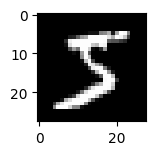

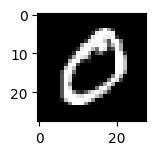

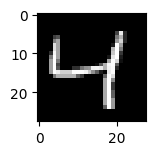

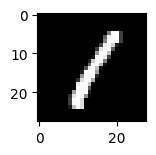

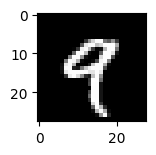

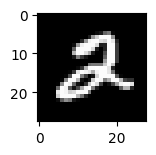

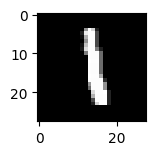

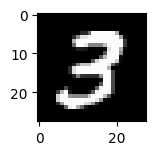

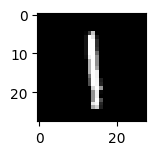

In [7]:
#phase 2
(train_X, train_y), (test_X, test_y) = mnist.load_data()

print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))
for i in range(9):
  plt.subplot(330 + 1 + i)
  plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))
  plt.show()


In [9]:
E=train_X.shape[0]
lis=[]
for i in range(E):
  img=train_X[i]
  patch=patchify(img,(8,8),step=8)
  for k in range(patch.shape[0]):
    for j in range(patch.shape[1]):
      single_patch=patch[k,j,:,:]
      singlee_patch=single_patch.reshape(64,1)
      lis.append(singlee_patch)

In [64]:
#second approach to extract patches
patch_size = 8
stride = 4
x_train=np.array(lisa1)
y=np.array(lisa)
# Extract patches from images
patches = []
patches1=[]
for img in x_train:
    for i in range(0, img.shape[0]-patch_size+1, stride):
        for j in range(0, img.shape[1]-patch_size+1, stride):
            patch = img[i:i+patch_size, j:j+patch_size]
            #plt.imshow(patch,cmap=plt.get_cmap('gray'))
            #plt.show()
            patches.append(patch.flatten())
for img in y:
    for i in range(0, img.shape[0]-patch_size+1, stride):
        for j in range(0, img.shape[1]-patch_size+1, stride):
            patch = img[i:i+patch_size, j:j+patch_size]
            #plt.imshow(patch,cmap=plt.get_cmap('gray'))
            #plt.show()
            patches1.append(patch.flatten())


In [127]:
def denoise_patch(patch, gmm):
    """
    Denoises a single patch using GMM prior.
    """
    num_components = gmm.n_components
    likelihoods = np.zeros(num_components)
    for i in range(num_components):
        likelihoods[i] = gmm.weights_[i] * gmm.means_[i].dot(patch) - \
                         0.5 * gmm.covariances_[i].dot(patch).dot(patch) + \
                         0.5 * np.log(np.linalg.det(gmm.covariances_[i])) - \
                         0.5 * patch.shape[0] * np.log(2 * np.pi)
    return gmm.means_[np.argmax(likelihoods)]

In [ ]:
patches =[]
patches1 =[]
for i in range(y.shape[0]):
  d=y[i,:,:]
  for j in range(0, d.shape[0] - patch_size+1,patch_size):
      for k in range(0, d.shape[1] - patch_size,patch_size):
          patch = d[j:j+patch_size, k:k+patch_size]
          patches.append(patch.ravel())
for i in range(x_train.shape[0]):
  d=x_train[i,:,:]
  for j in range(0, d.shape[0] - patch_size+1,patch_size):
      for k in range(0, d.shape[1] - patch_size,patch_size):
          patch = d[j:j+patch_size, k:k+patch_size]
          patches1.append(patch.ravel())






In [132]:
# Train GMM on flattened patches
gmm = GaussianMixture(n_components=64)
gmm.fit(patches1)

GaussianMixture(n_components=64)

In [133]:
def reconstruct_from_patches(patches, image_shape, patch_size):
    """
    Reconstructs an image from patches.
    """


    m=[]
    k=0
    patch_size=8
    for u in range(y.shape[0]):
      d=y[u,:,:]
      data = np.zeros(d.shape)
      counts = np.zeros(d.shape)
      for i in range(0, d.shape[0] - patch_size,patch_size):
              for j in range(0, d.shape[1]- patch_size,patch_size):
                 patch = patches[k].reshape(patch_size, patch_size)
                 data[i:i+patch_size, j:j+patch_size] += patch
                 counts[i:i+patch_size, j:j+patch_size] += 1
                 k += 1
      m.append(data)

    return m

In [134]:
def denoise_mnist(patches, gmm,y,patch_size):
    """
    Denoises MNIST data with patch-based denoising using GMM prior.
    """
    # Denoise patches
    denoised_patches = np.zeros_like(patches)
    for i in range(len(patches)):
        denoised_patches[i] = denoise_patch(patches[i], gmm)
        # Reshape patches to original image shape
    denoised_data = reconstruct_from_patches(denoised_patches, y.shape, patch_size)

    return denoised_data

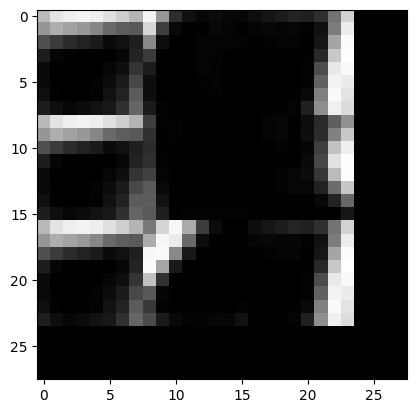

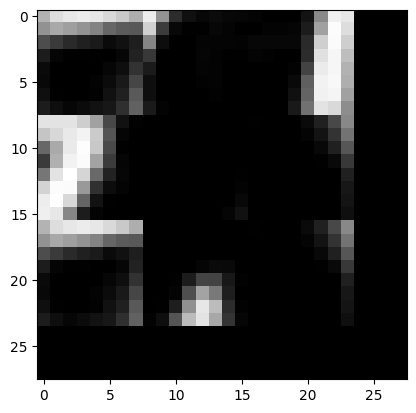

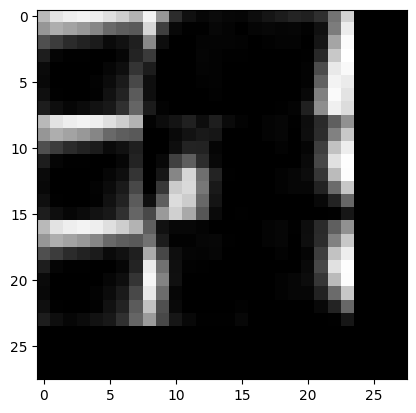

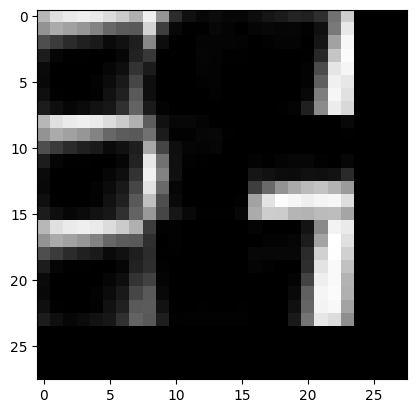

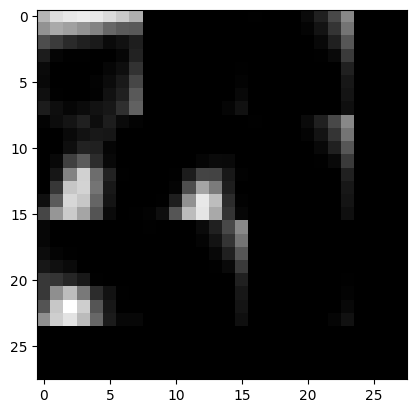

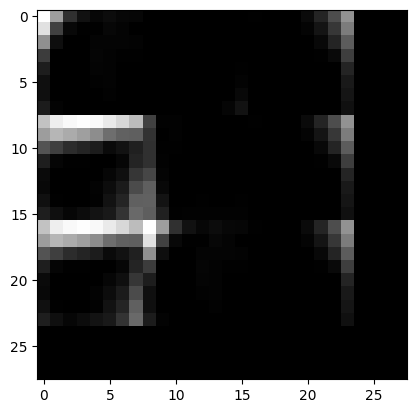

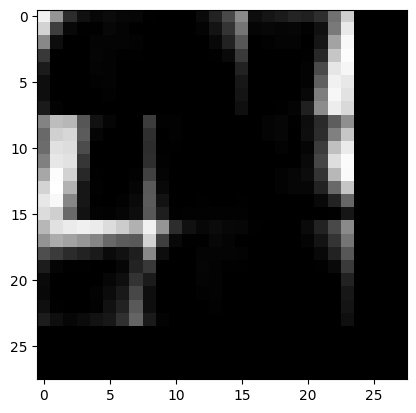

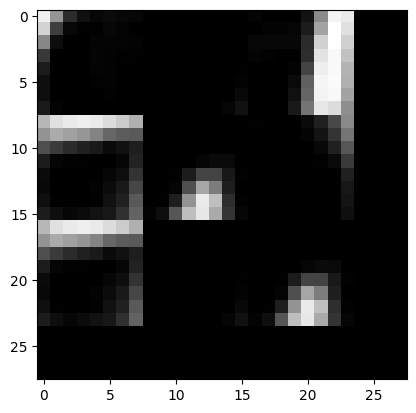

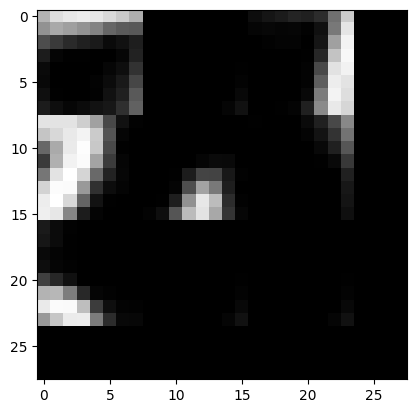

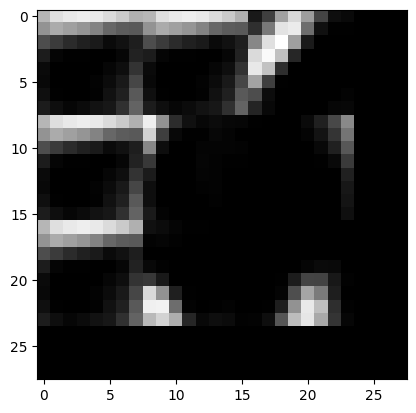

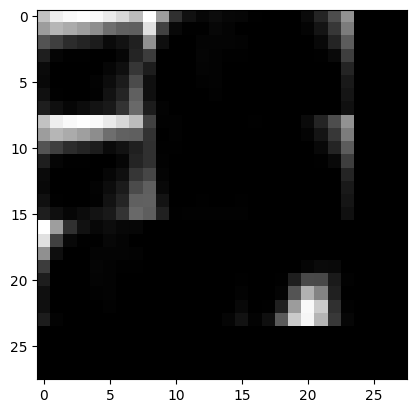

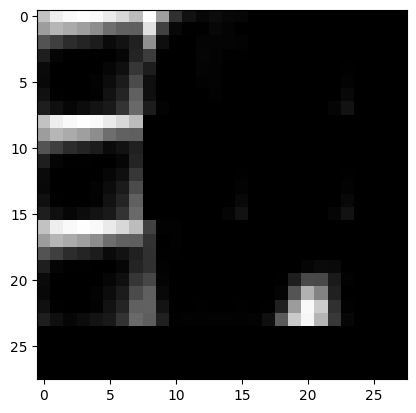

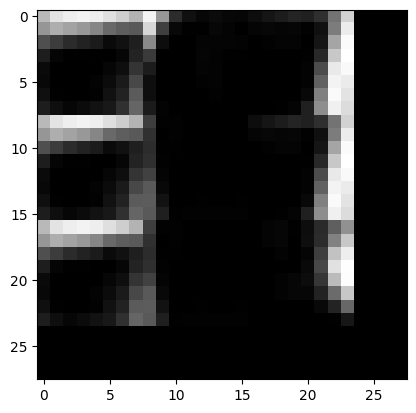

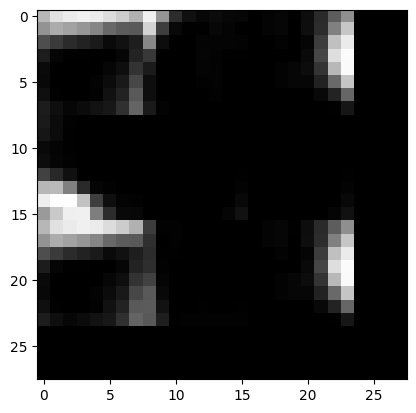

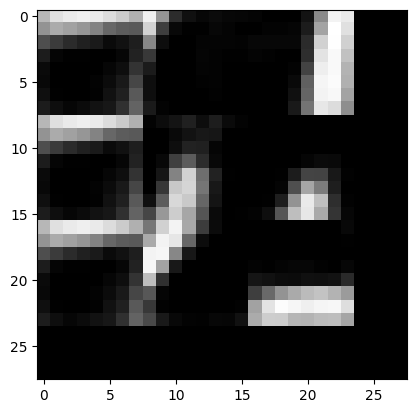

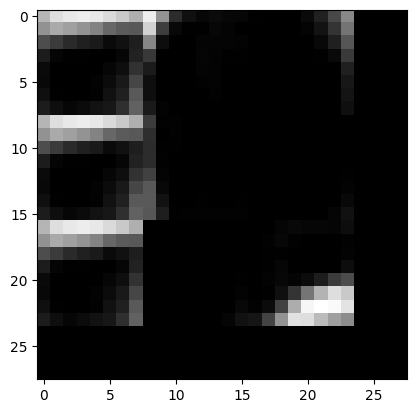

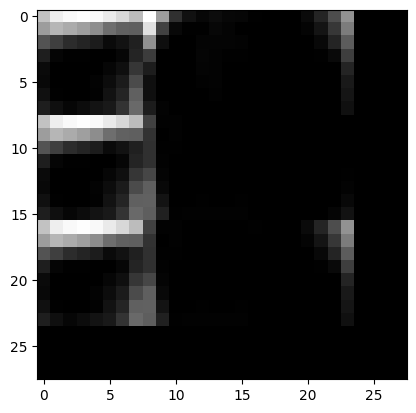

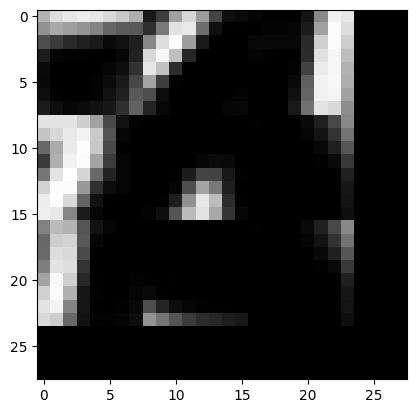

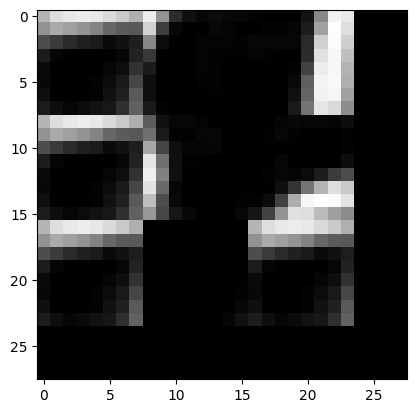

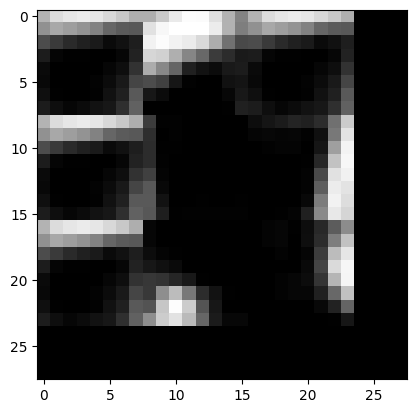

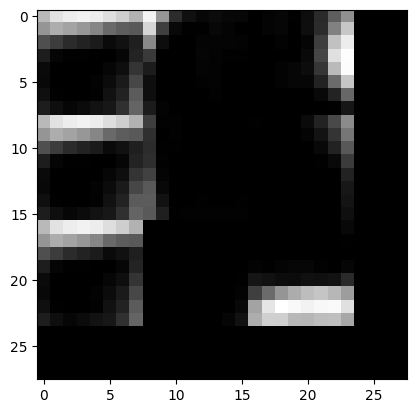

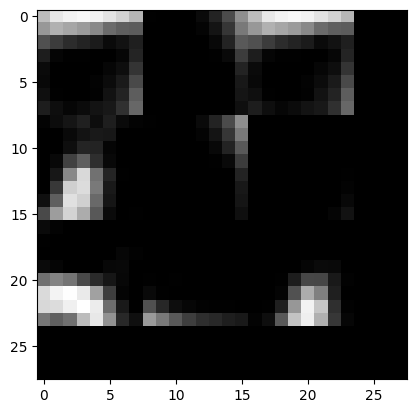

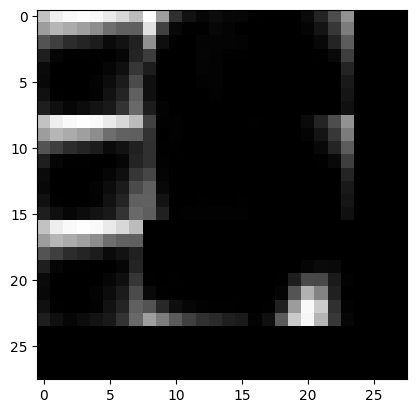

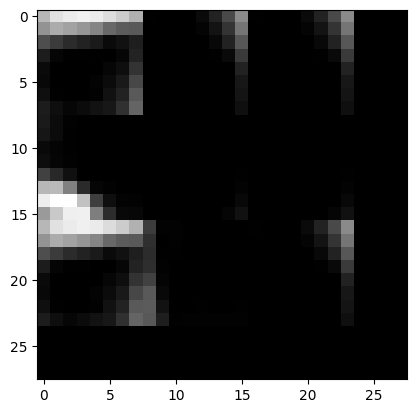

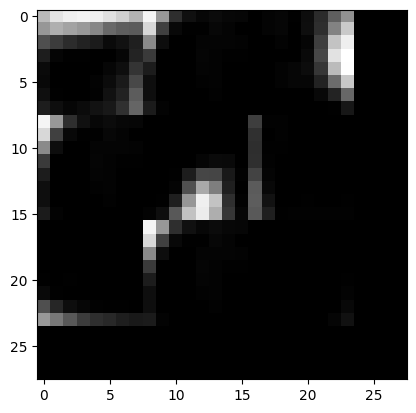

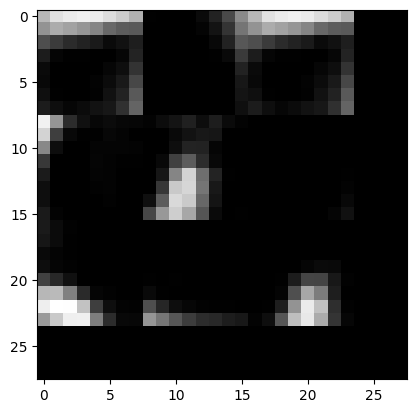

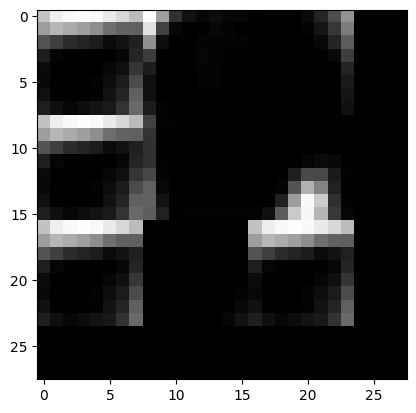

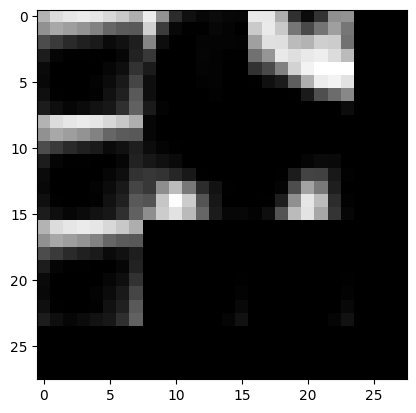

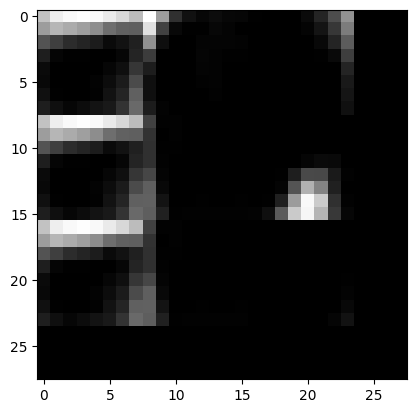

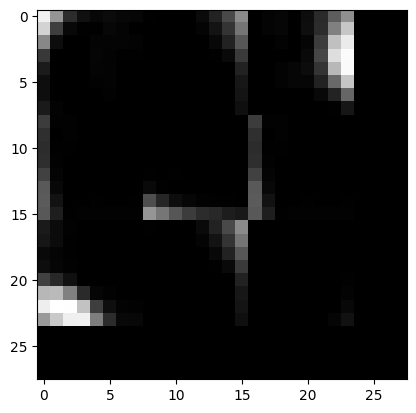

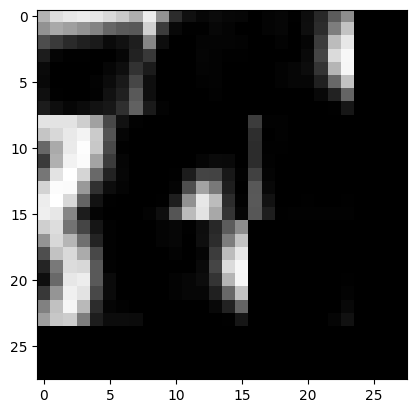

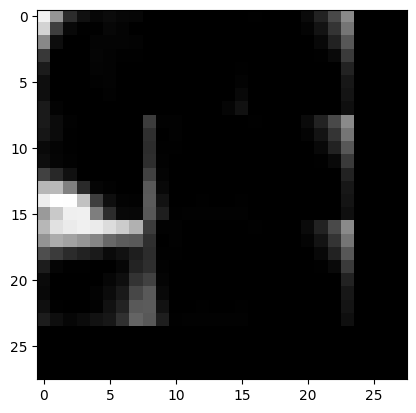

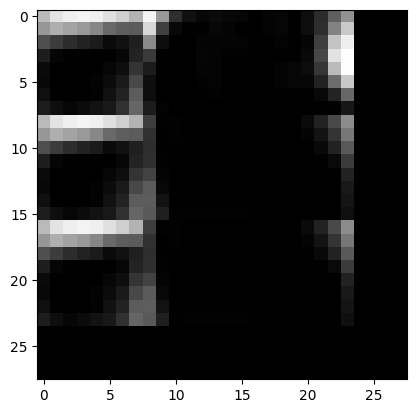

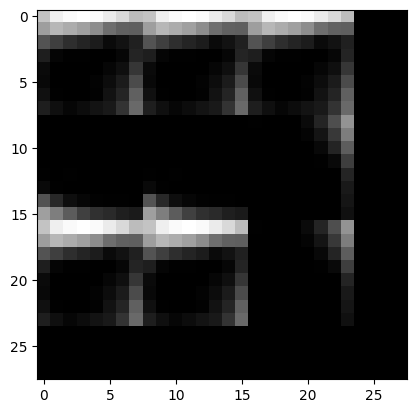

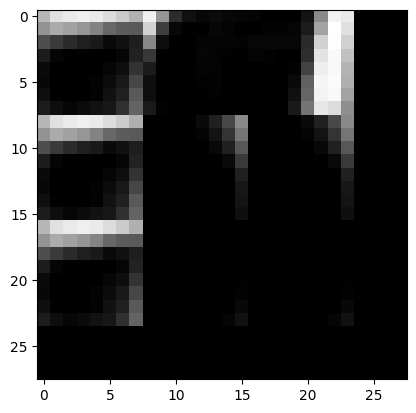

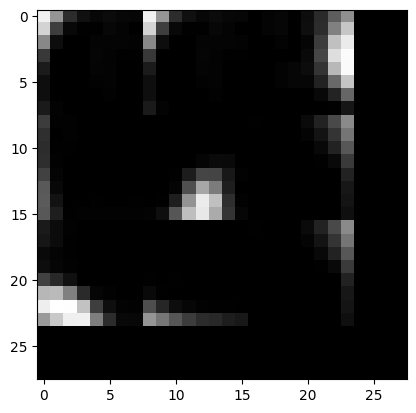

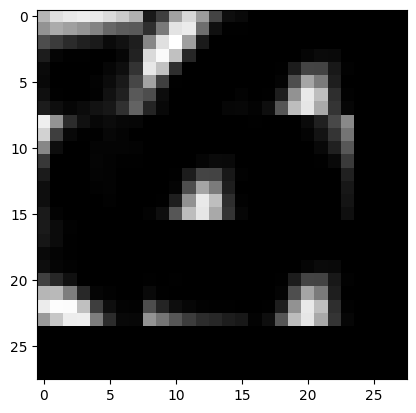

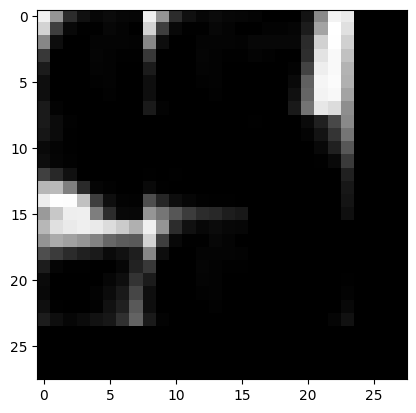

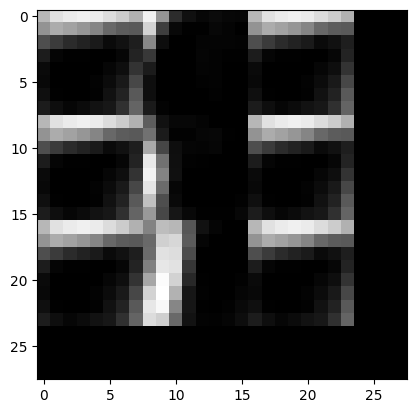

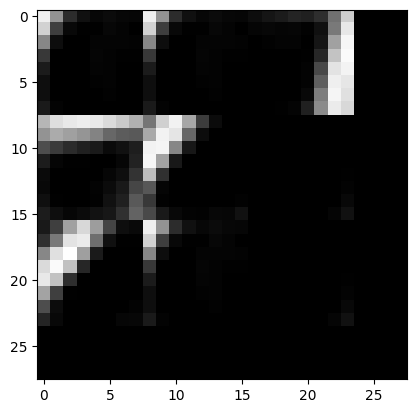

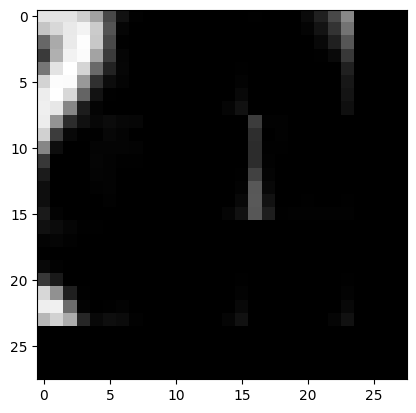

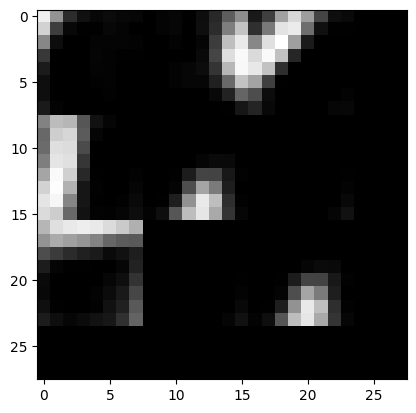

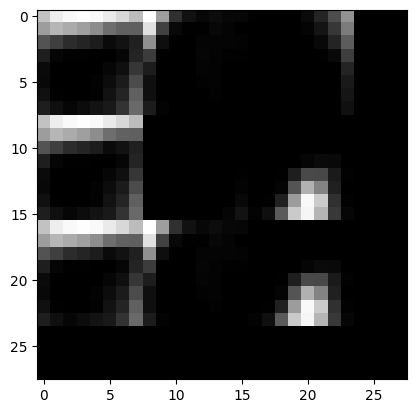

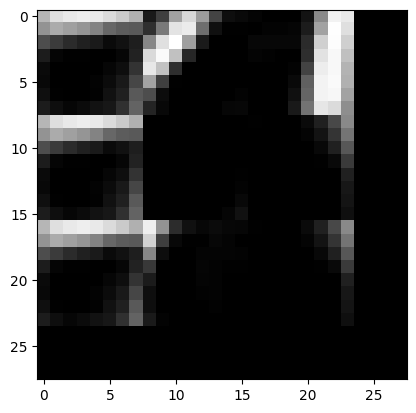

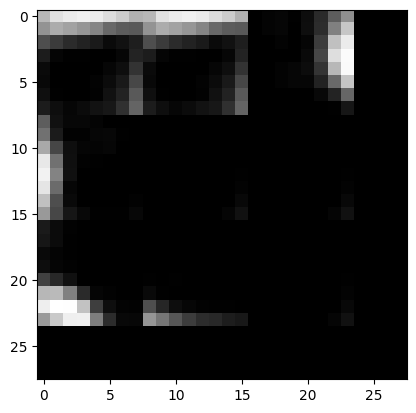

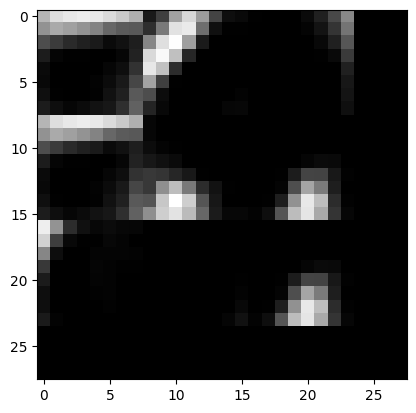

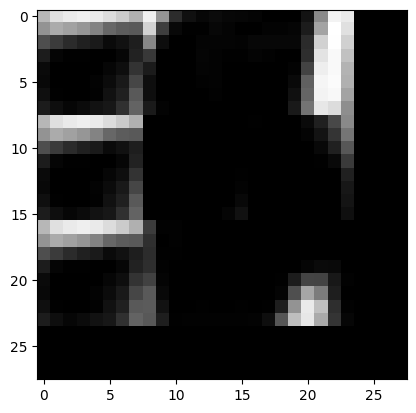

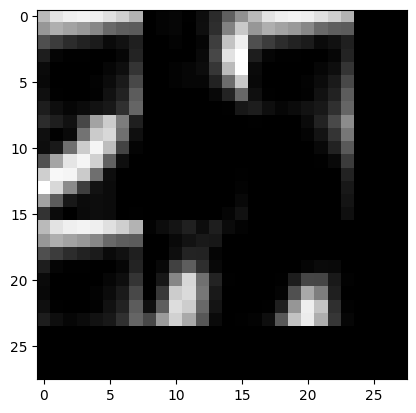

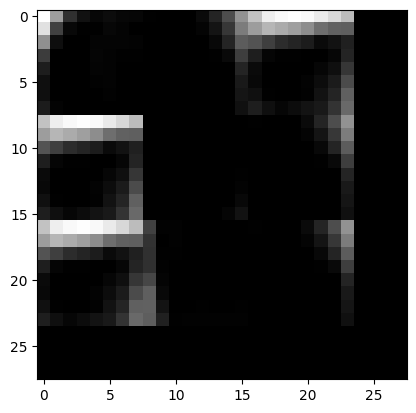

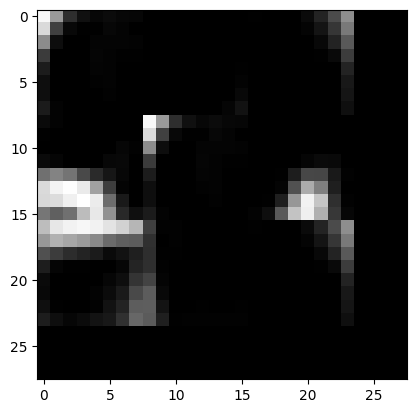

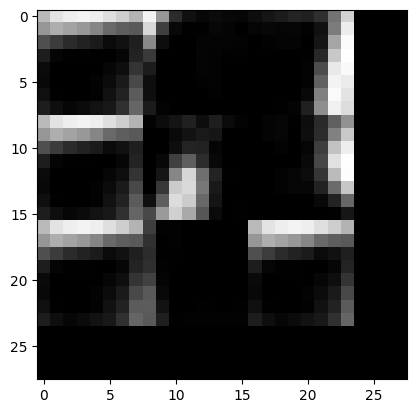

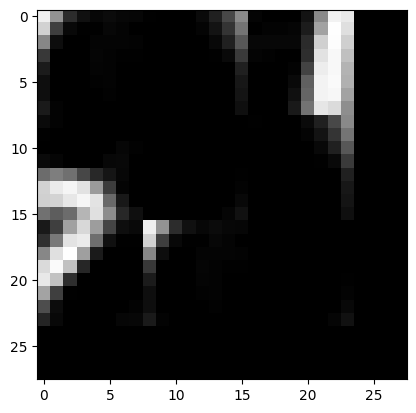

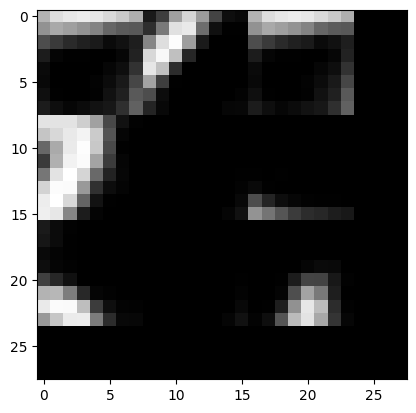

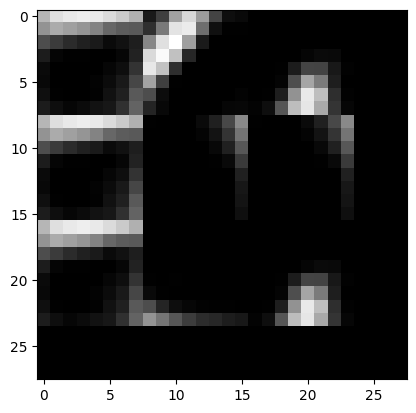

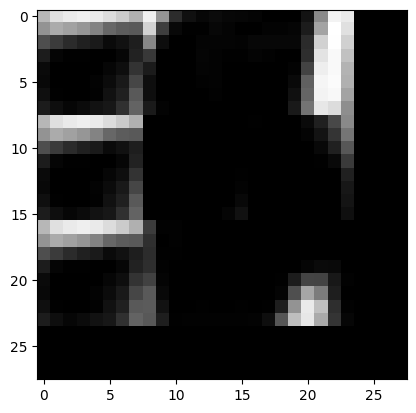

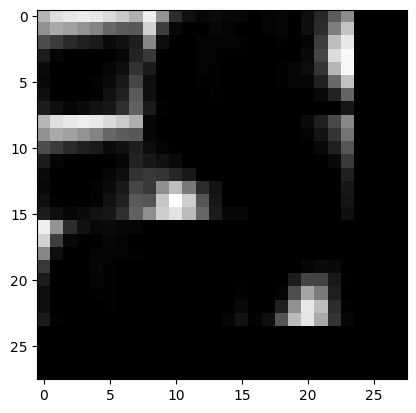

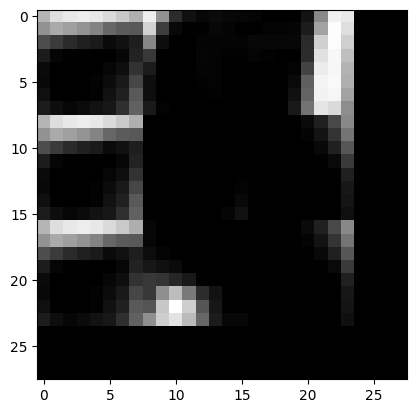

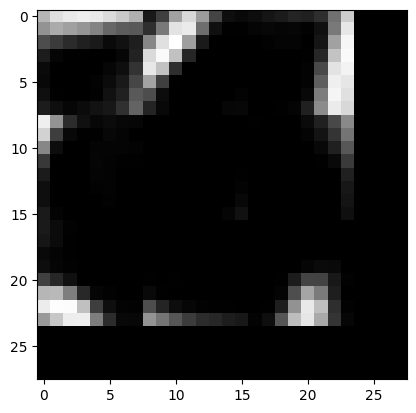

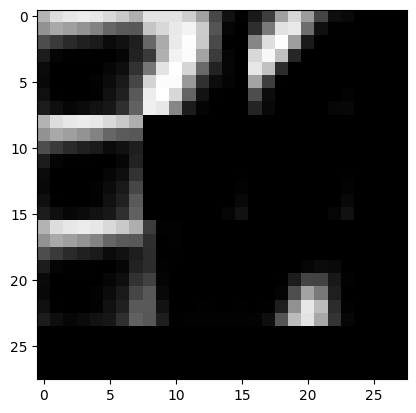

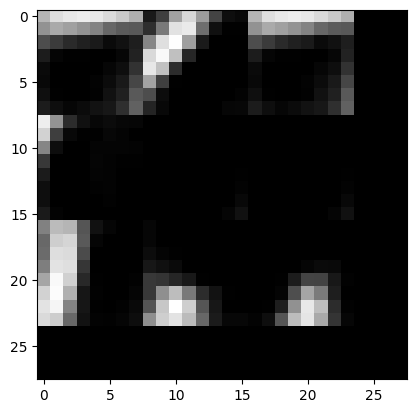

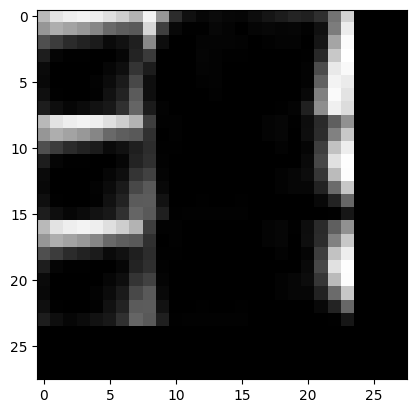

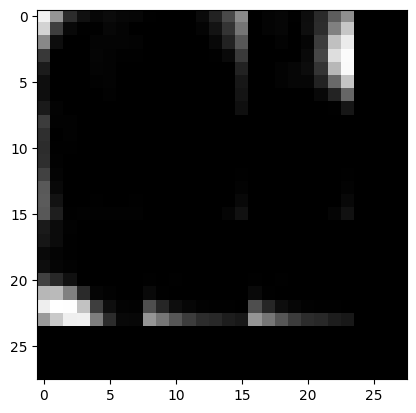

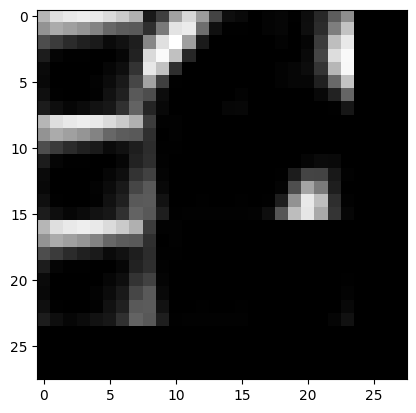

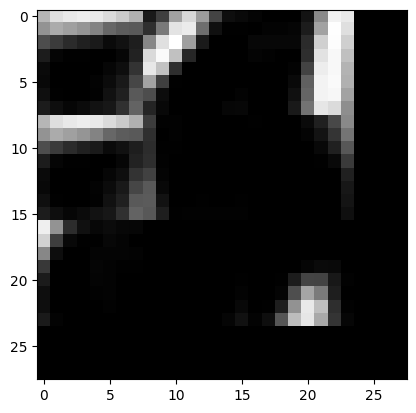

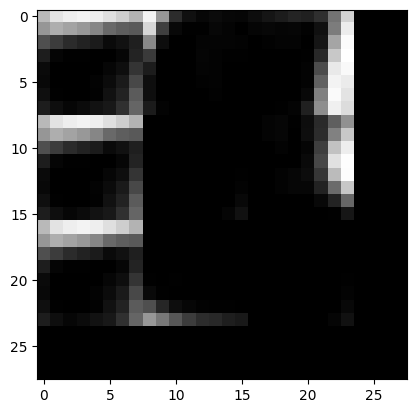

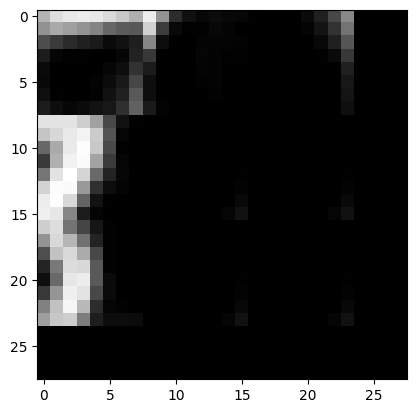

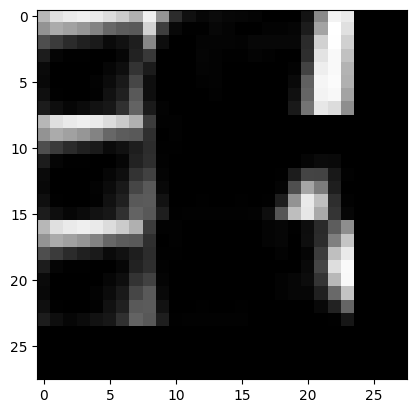

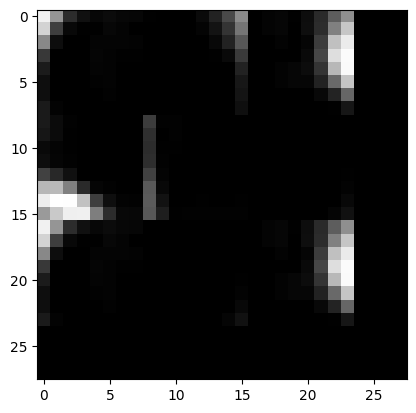

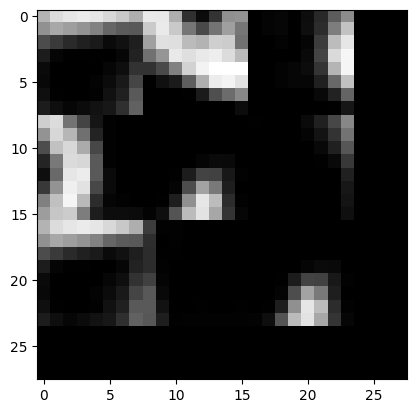

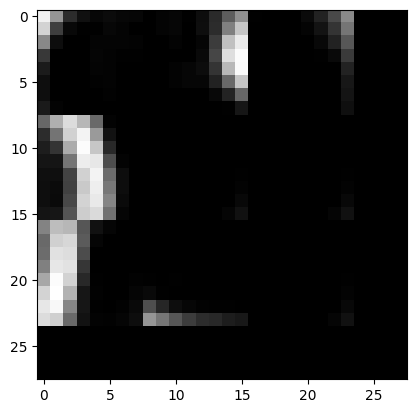

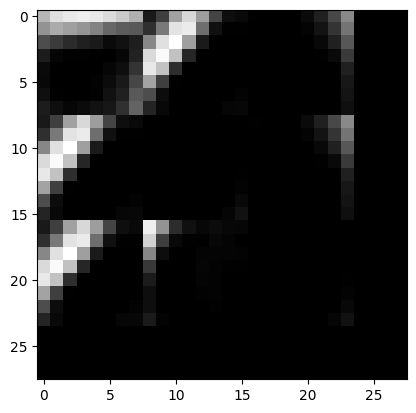

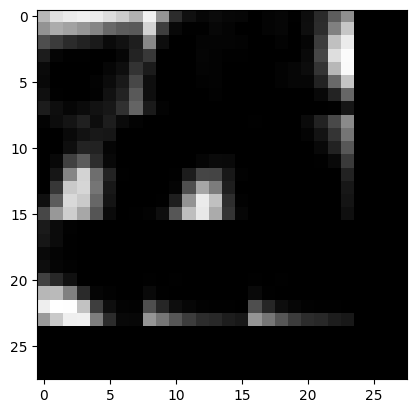

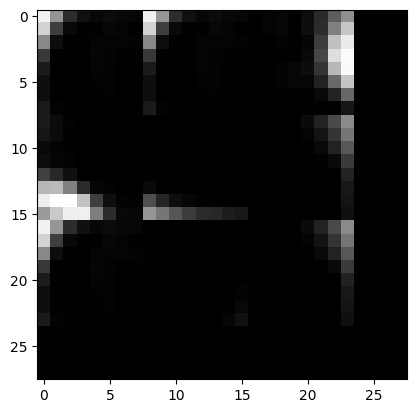

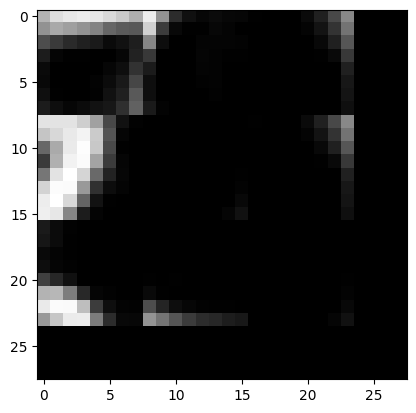

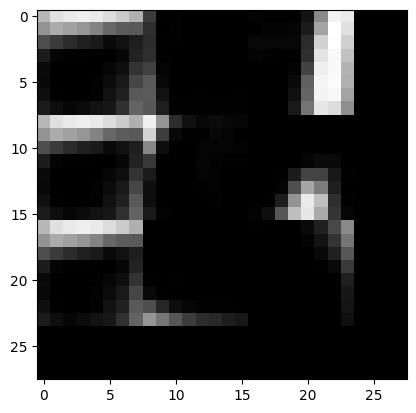

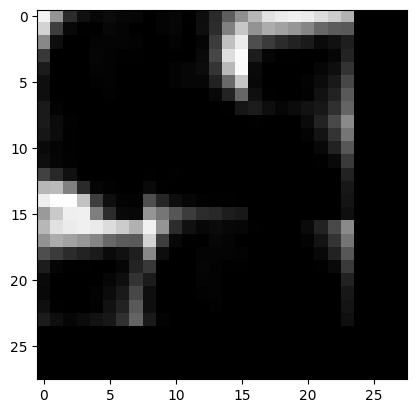

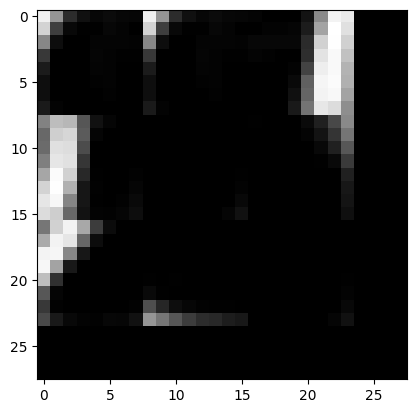

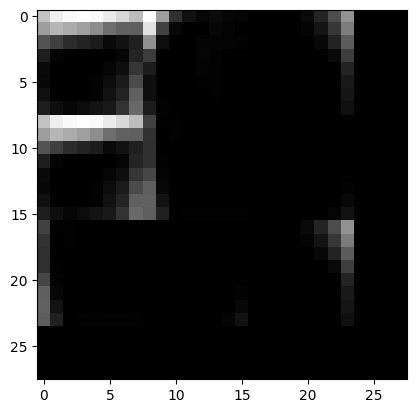

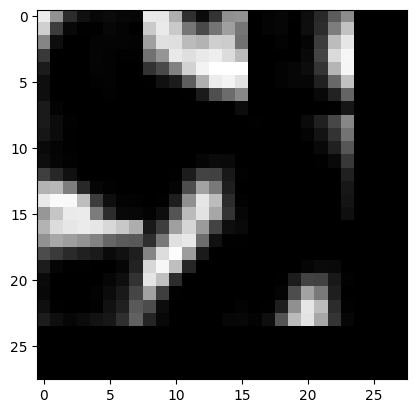

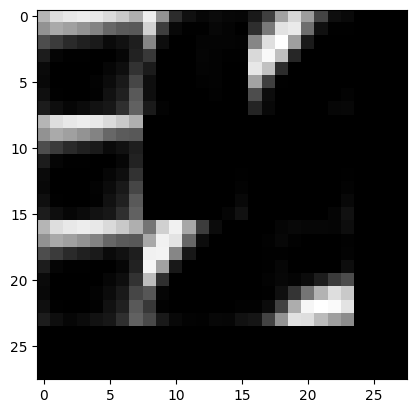

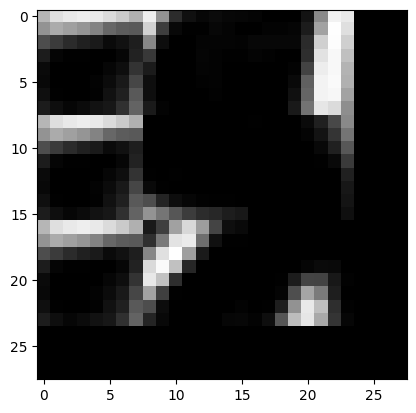

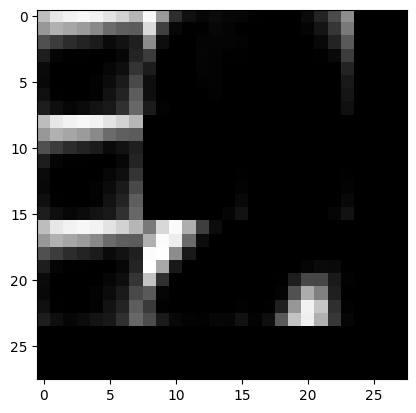

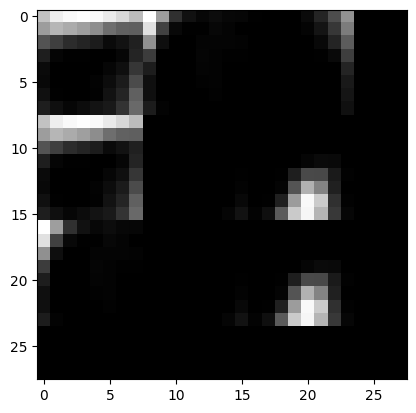

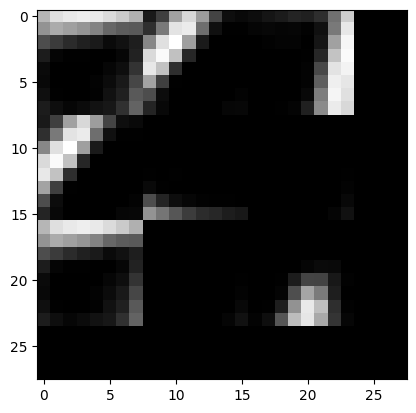

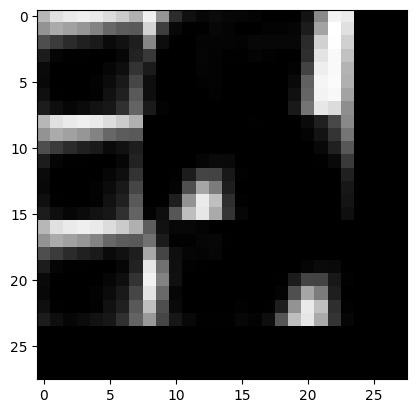

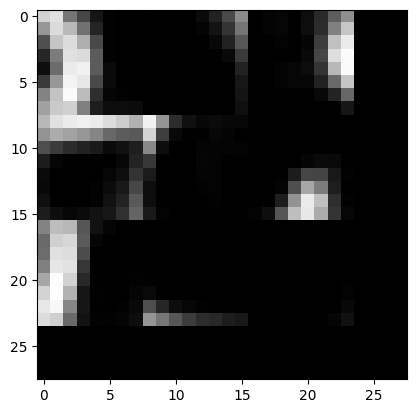

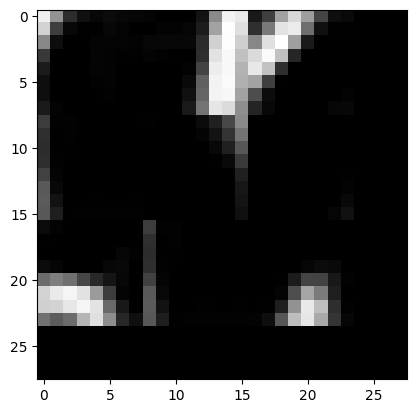

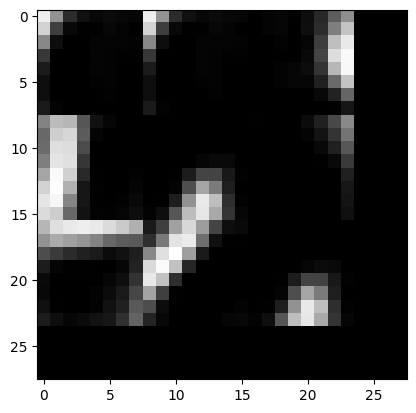

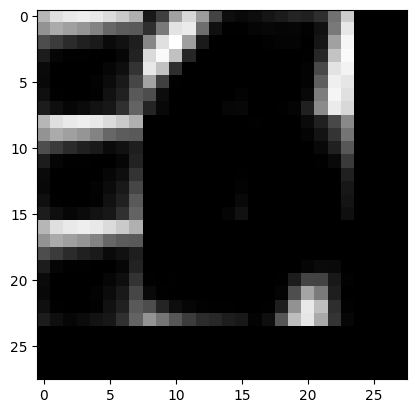

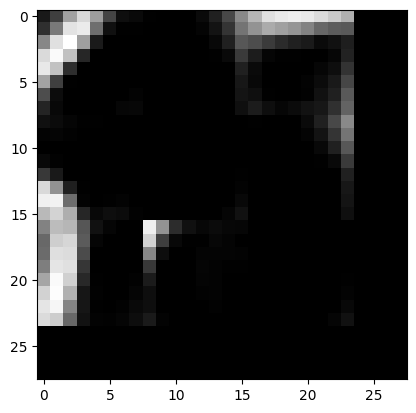

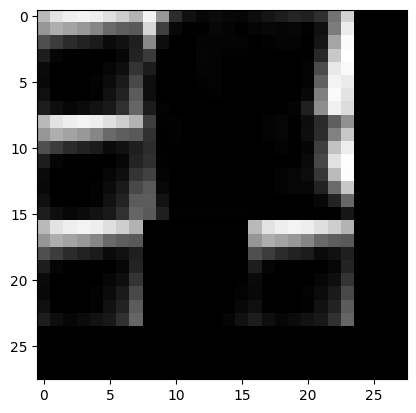

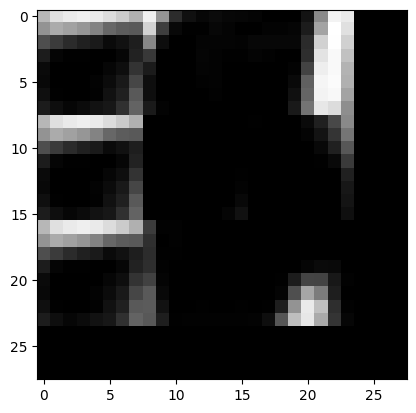

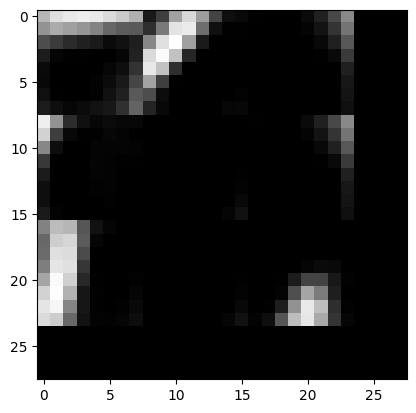

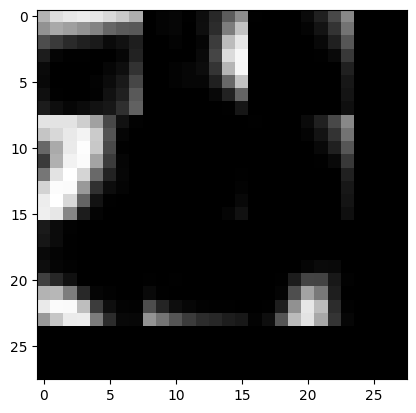

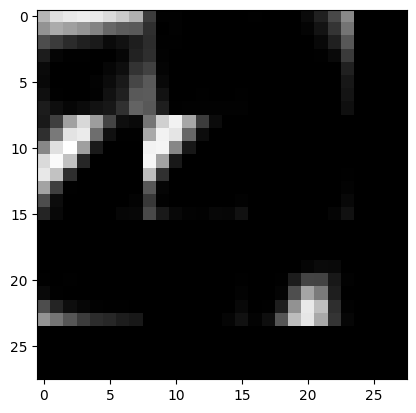

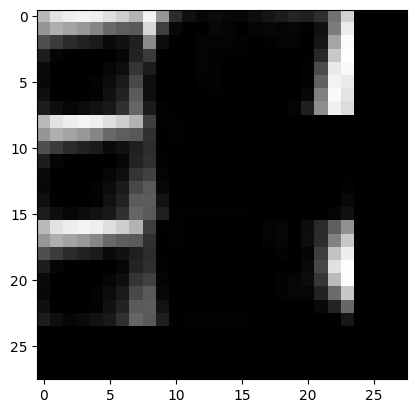

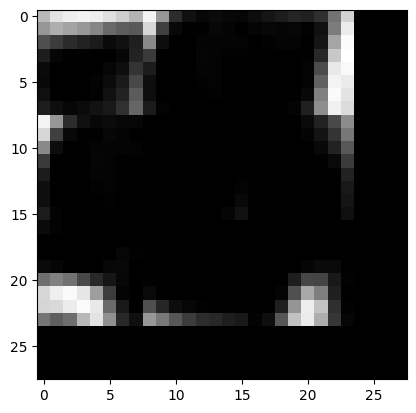

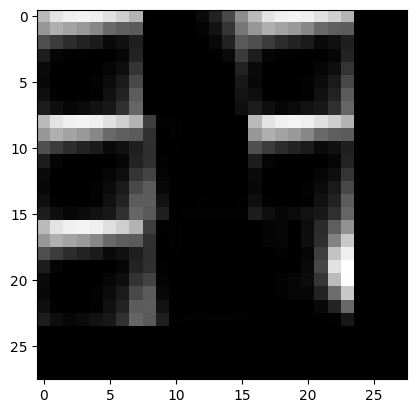

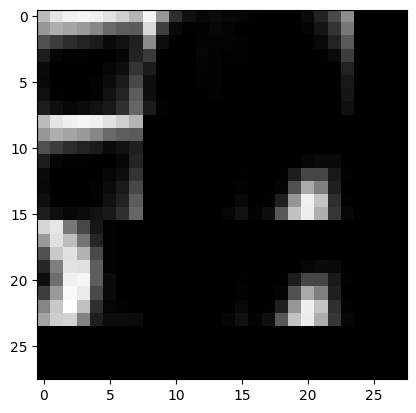

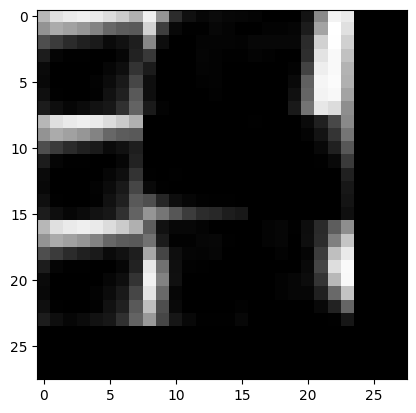

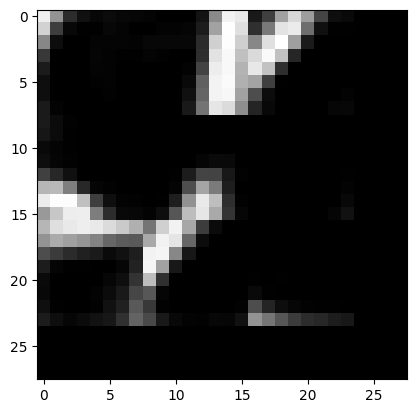

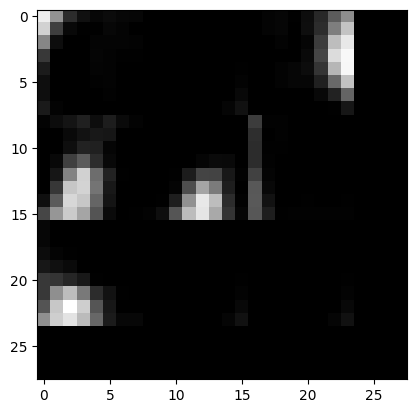

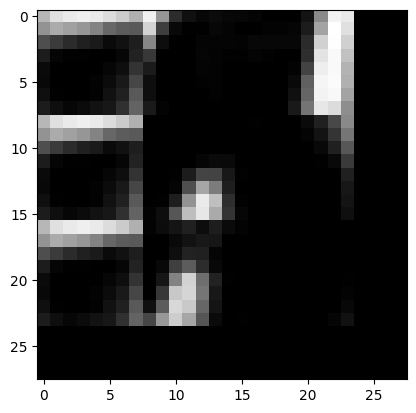

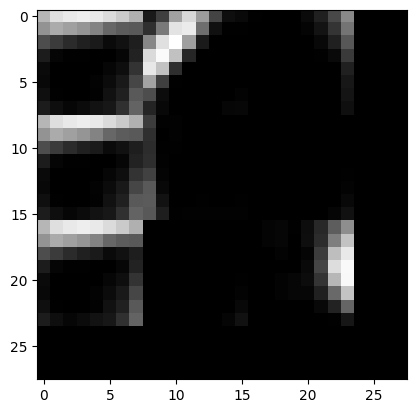

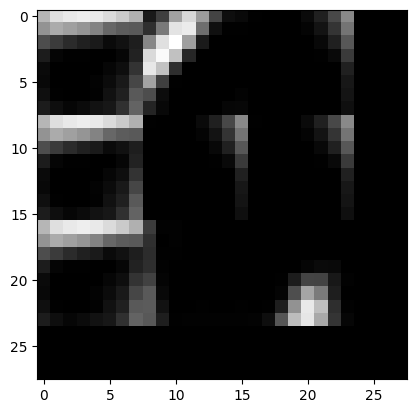

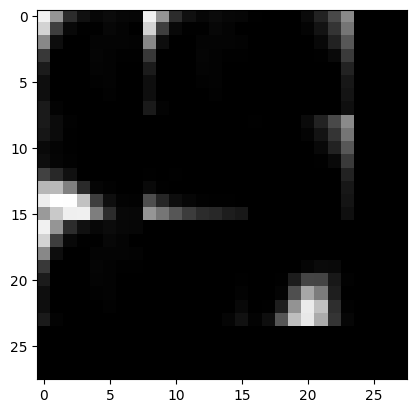

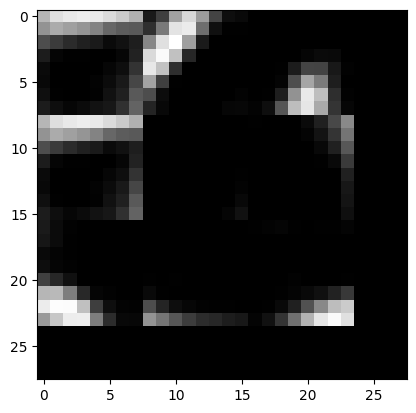

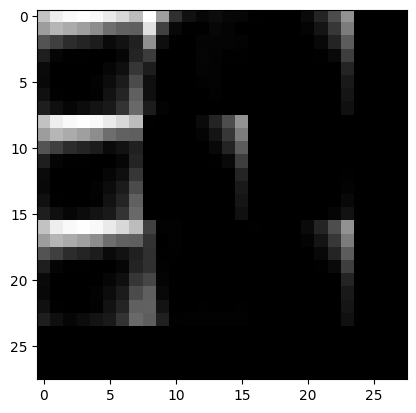

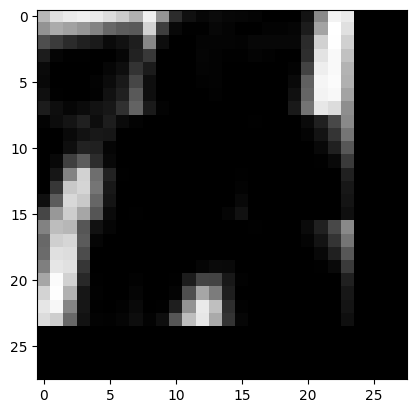

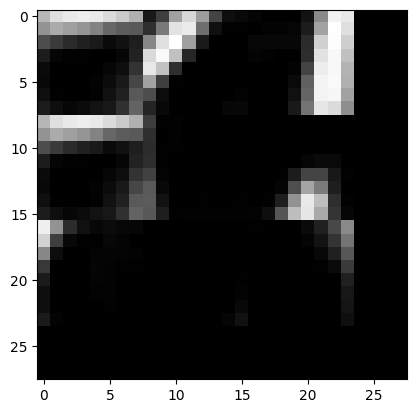

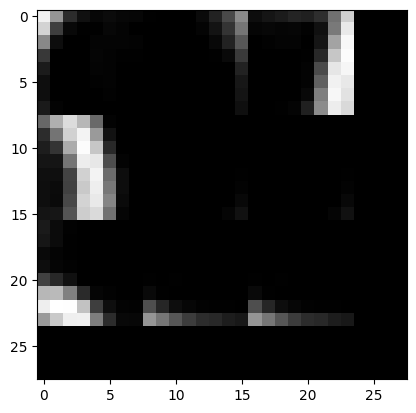

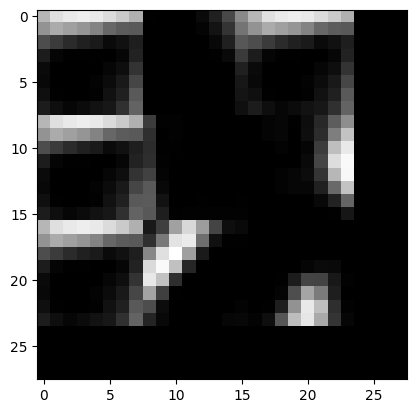

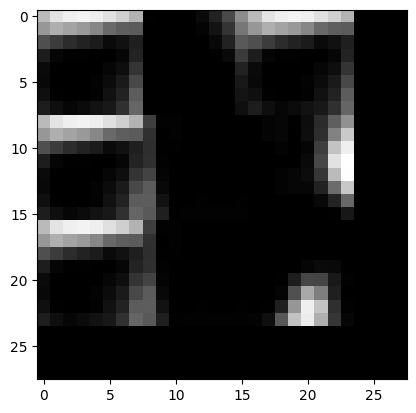

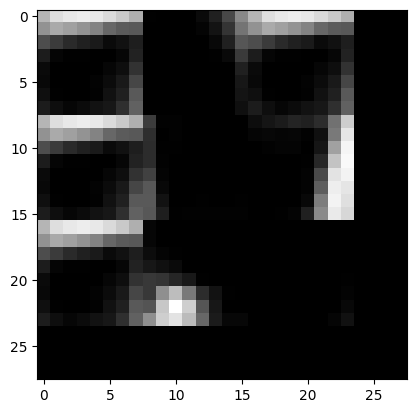

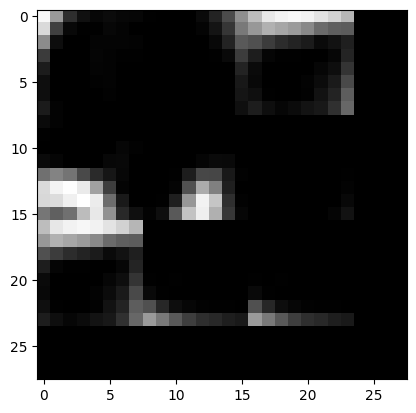

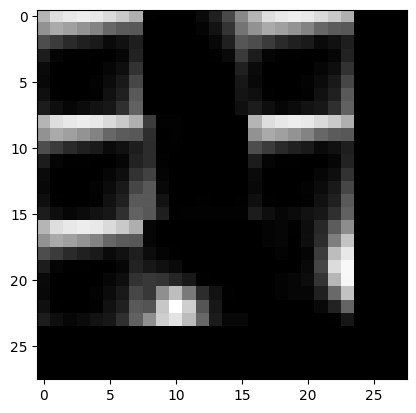

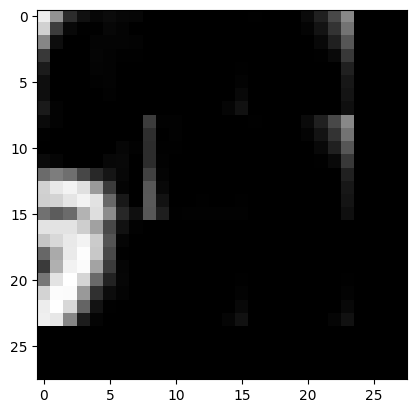

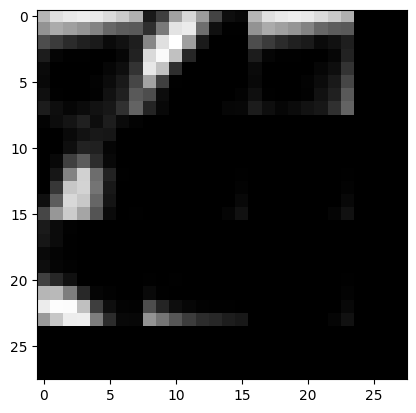

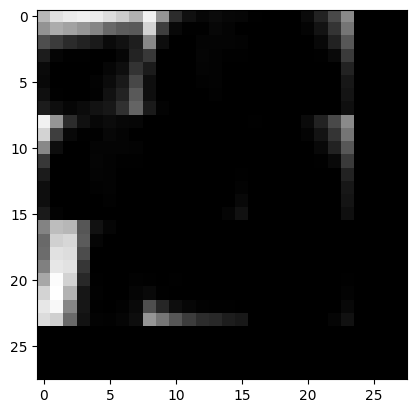

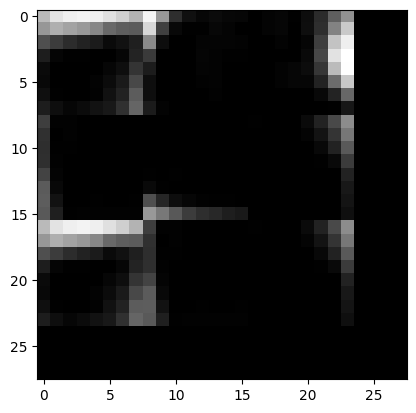

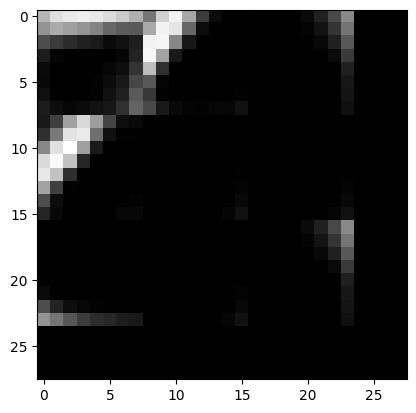

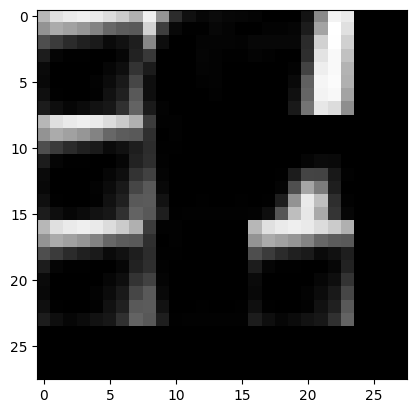

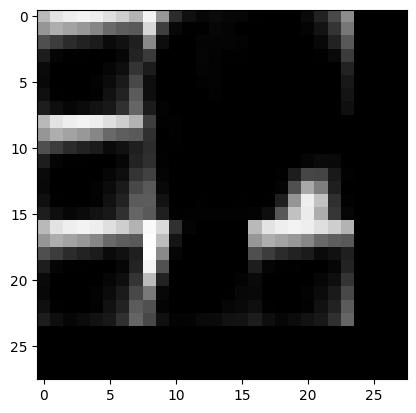

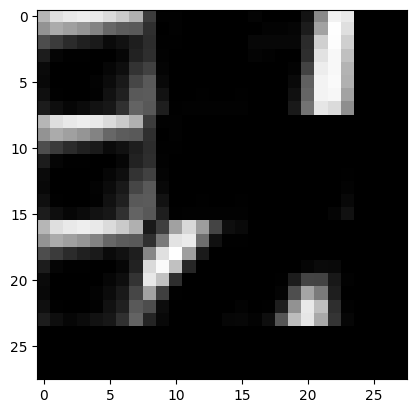

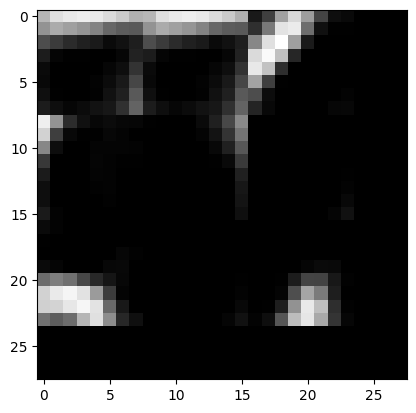

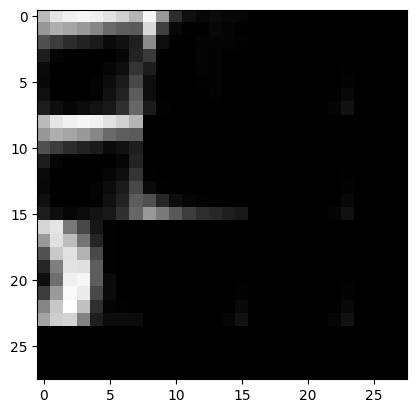

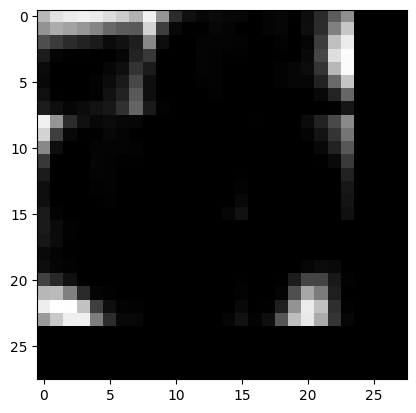

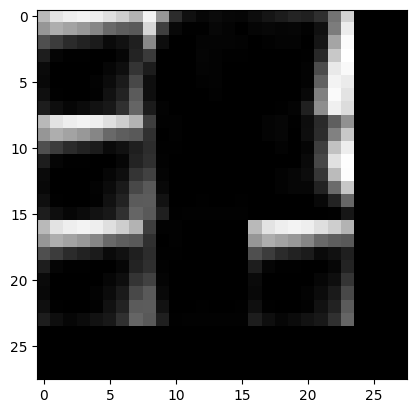

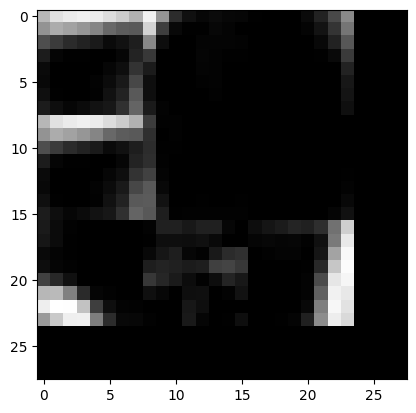

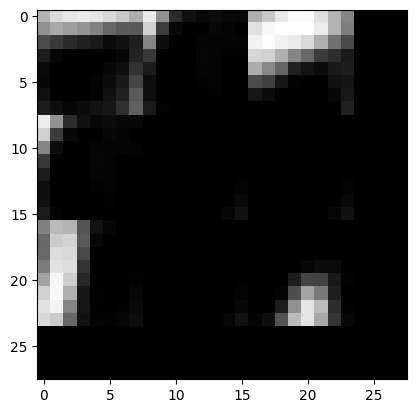

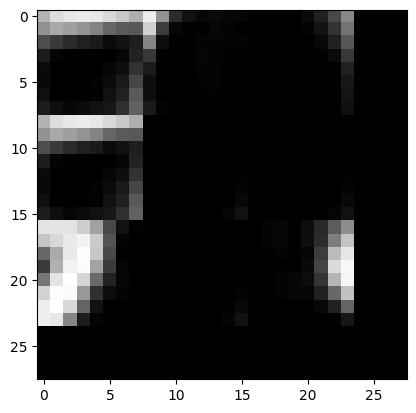

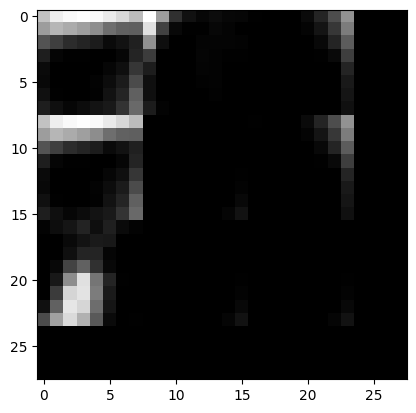

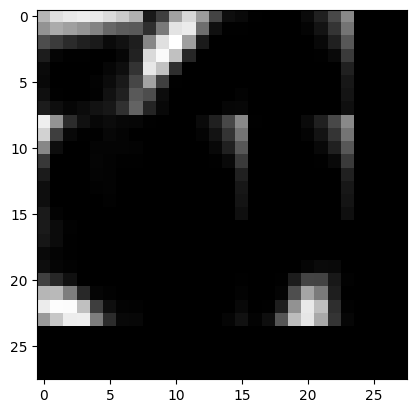

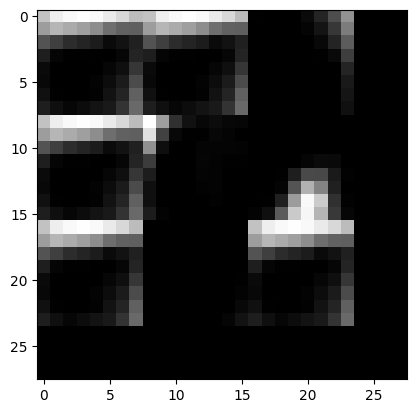

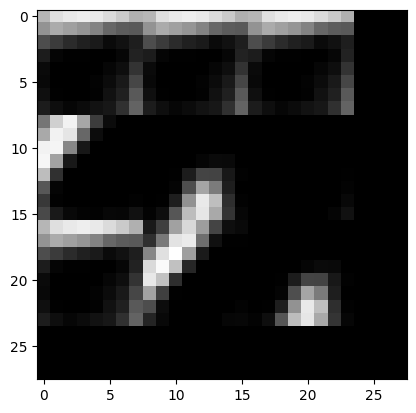

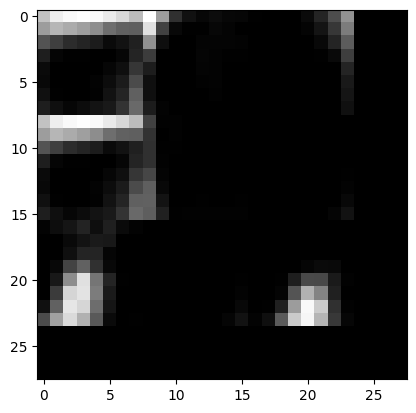

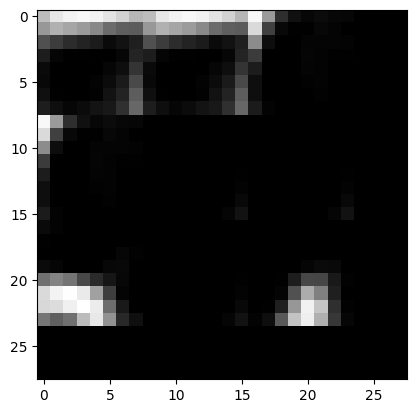

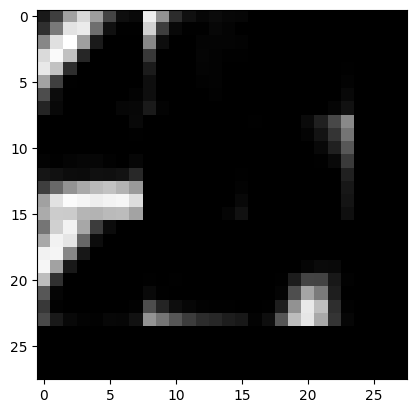

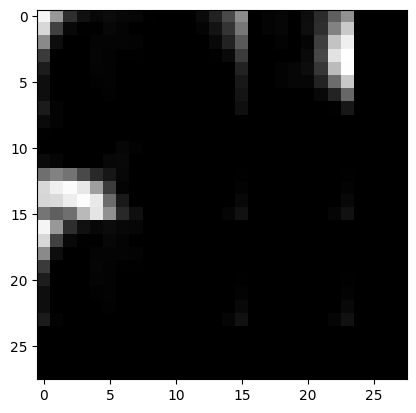

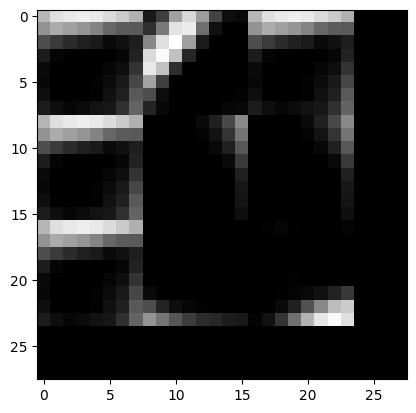

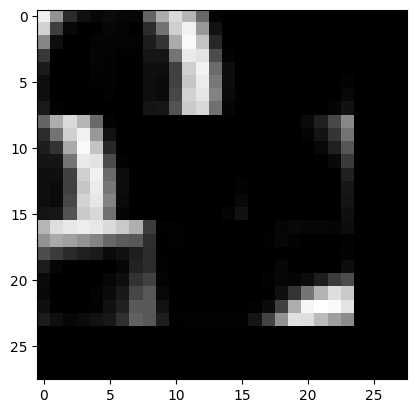

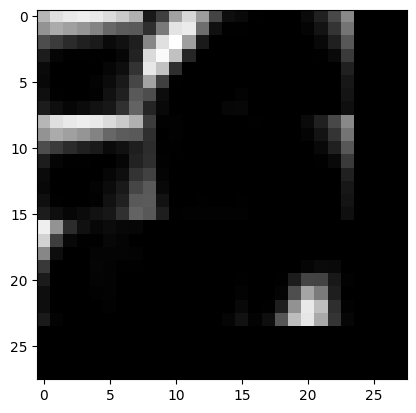

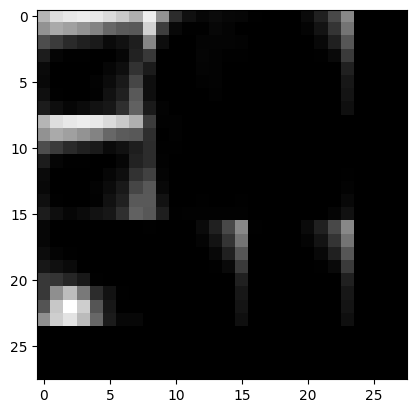

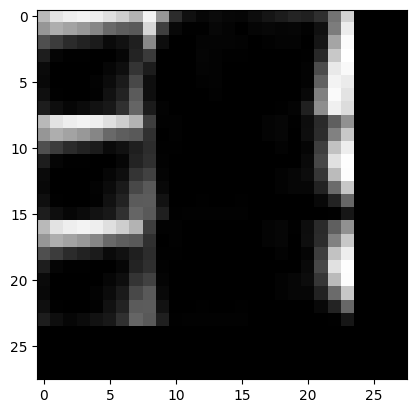

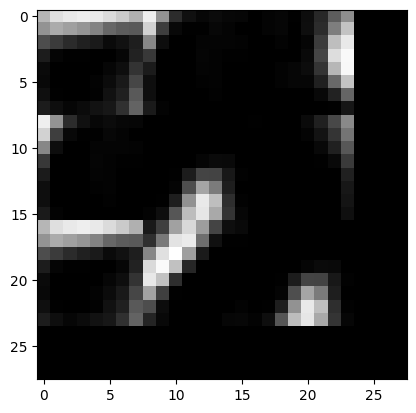

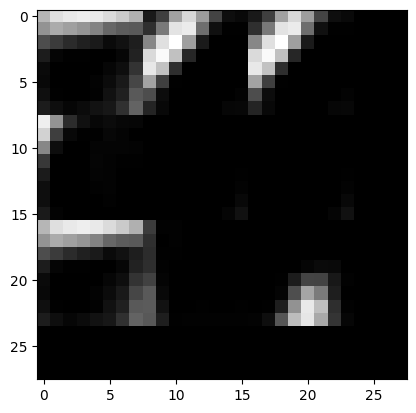

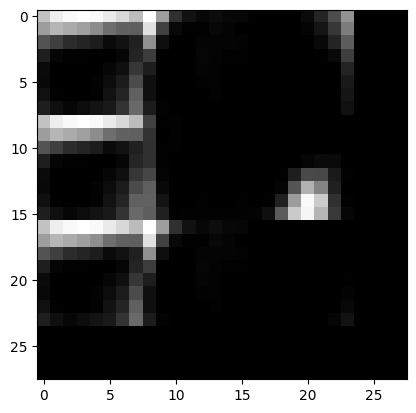

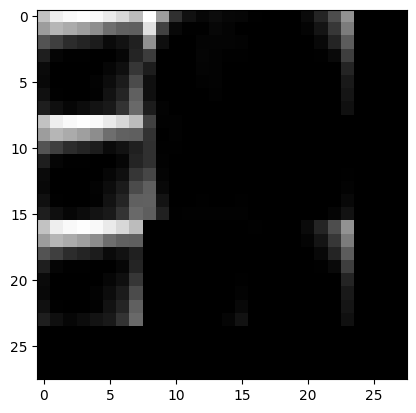

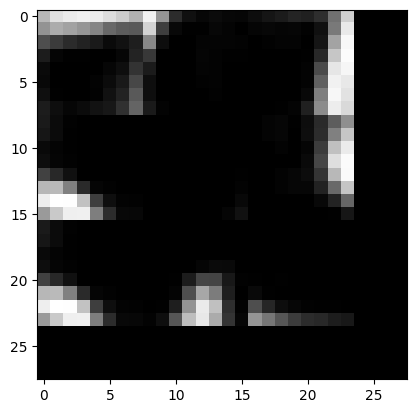

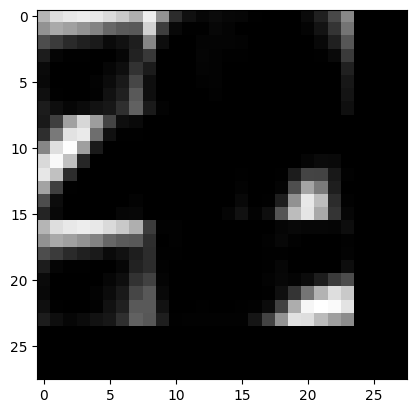

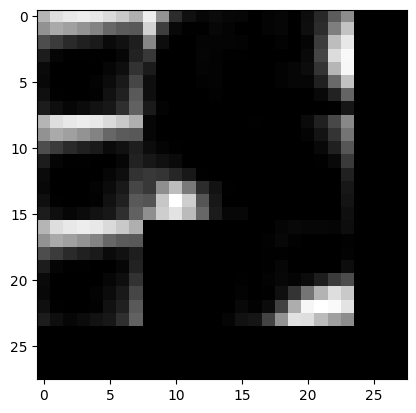

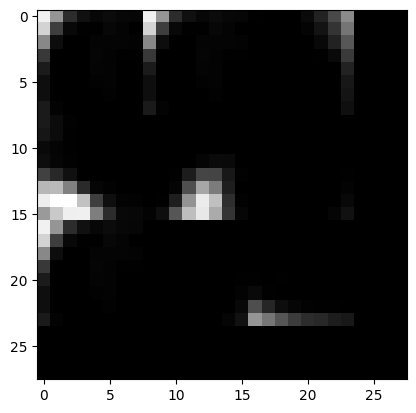

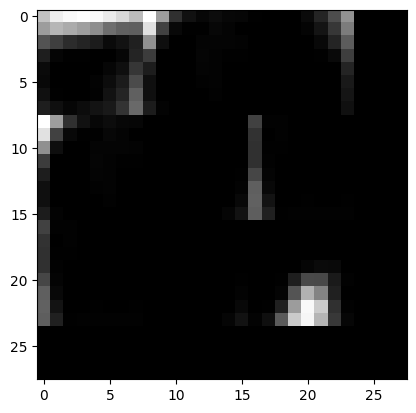

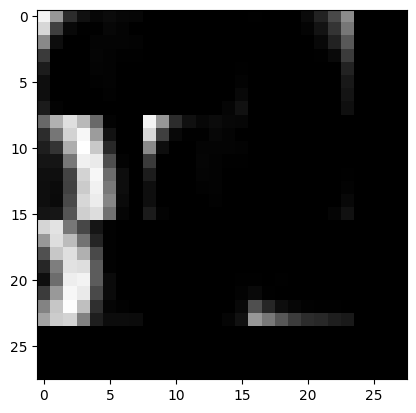

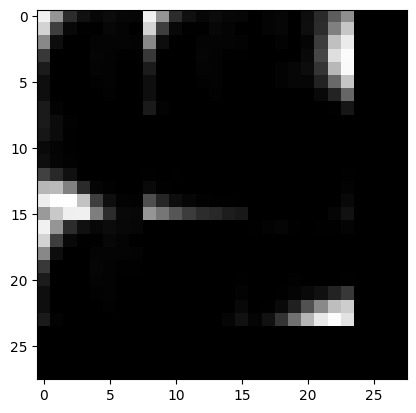

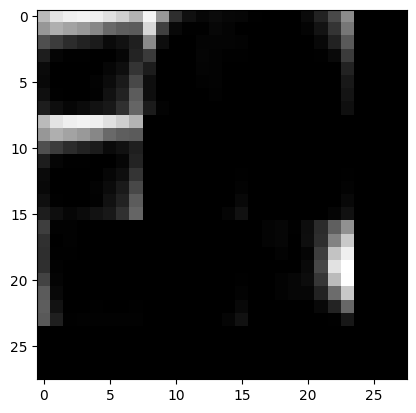

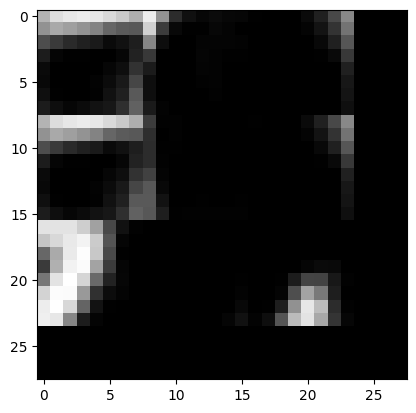

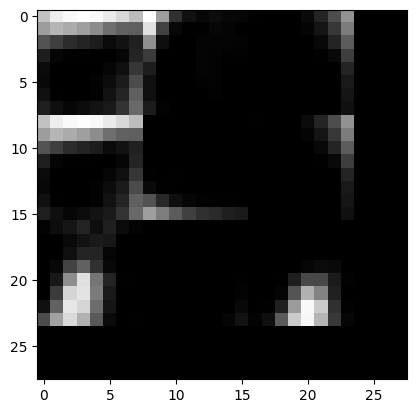

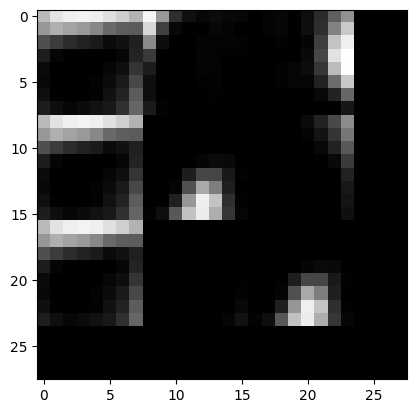

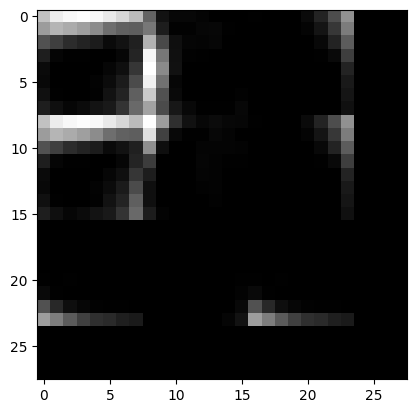

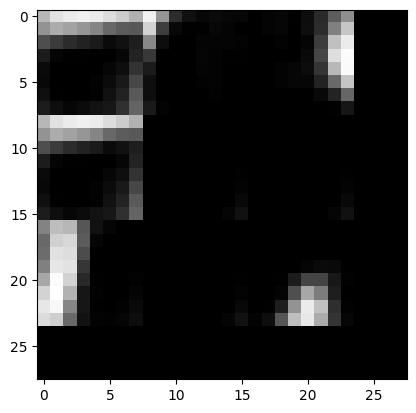

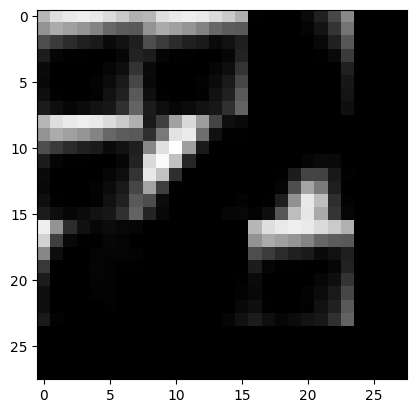

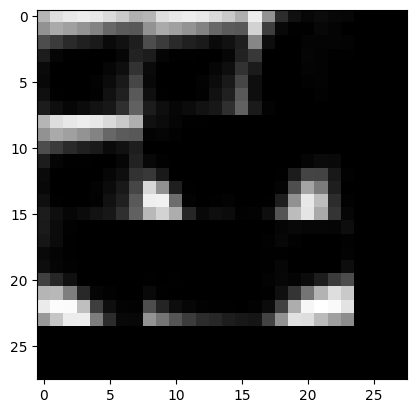

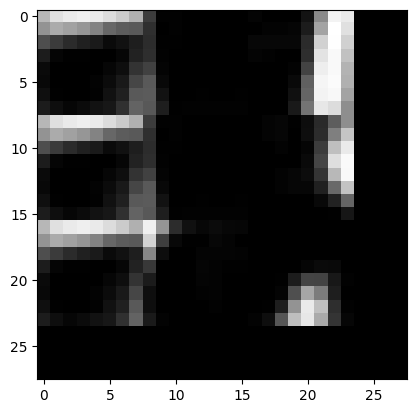

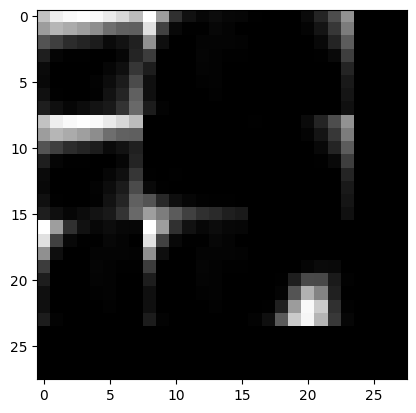

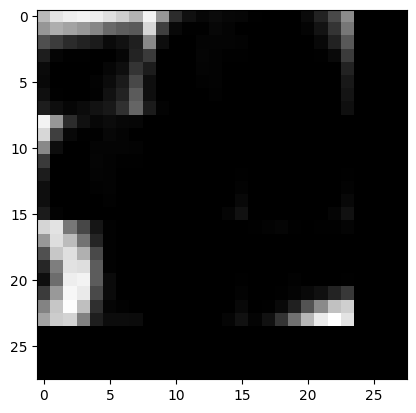

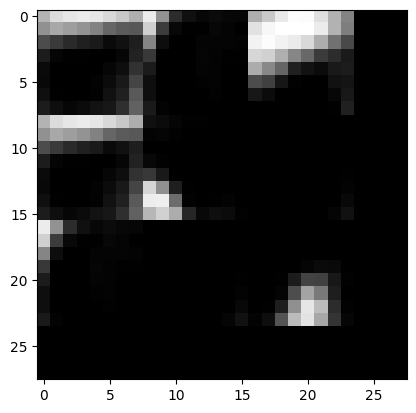

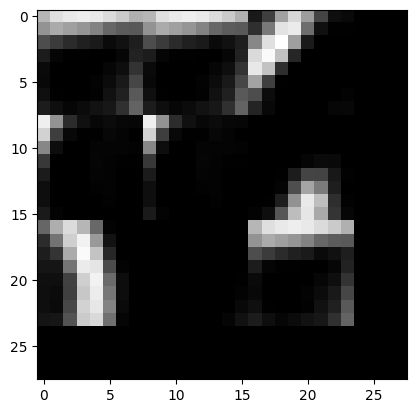

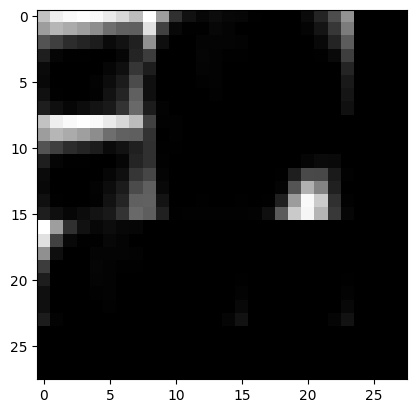

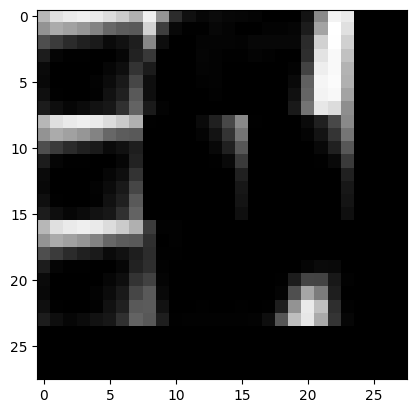

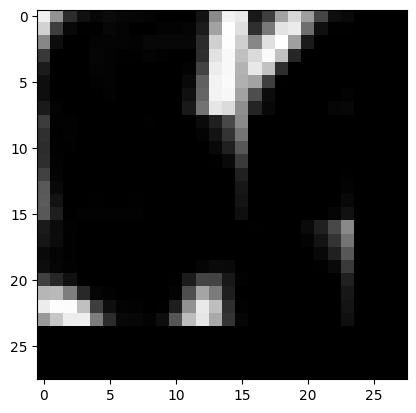

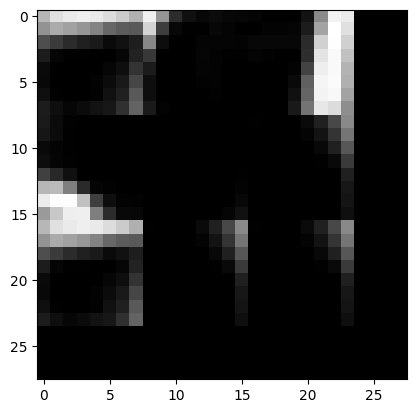

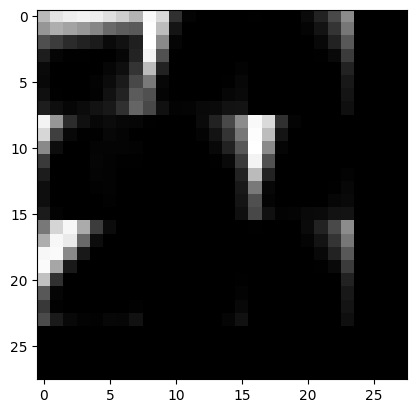

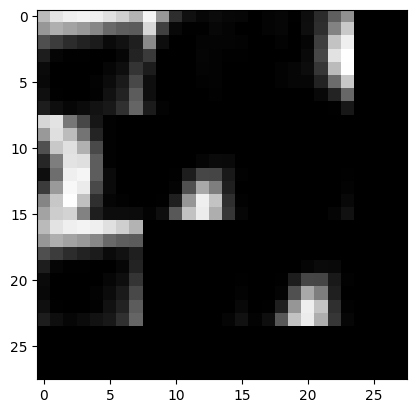

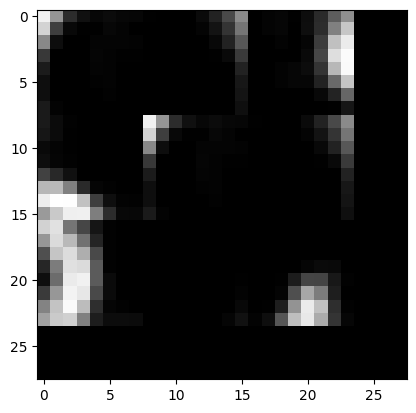

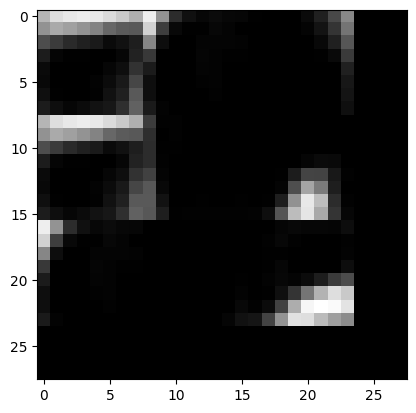

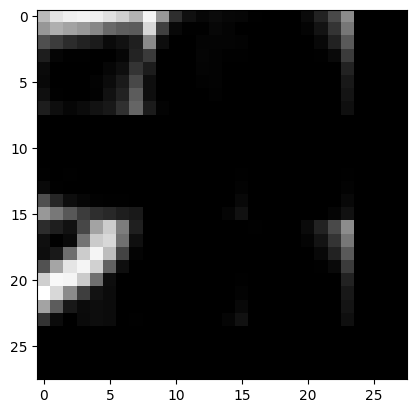

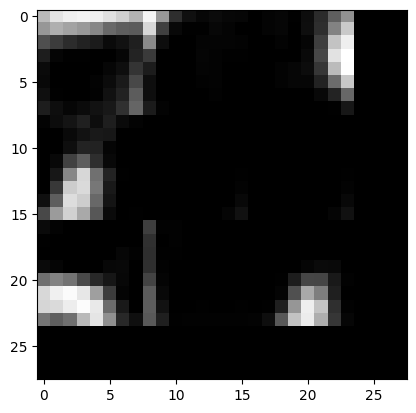

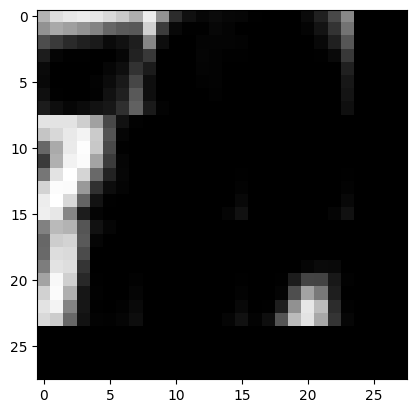

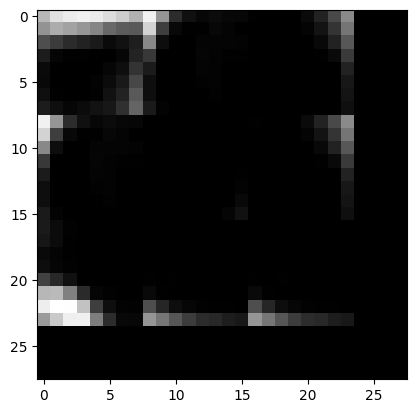

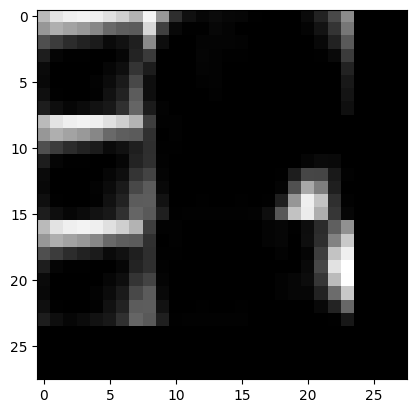

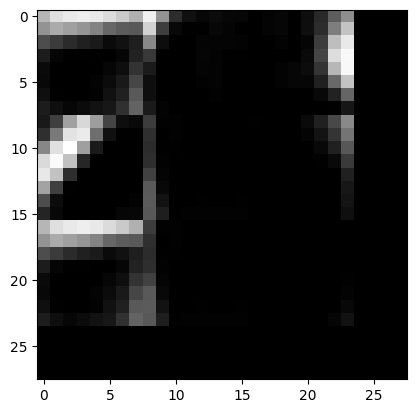

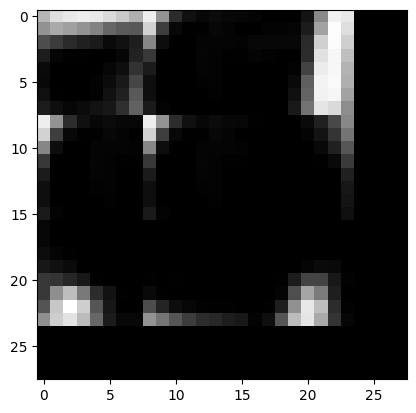

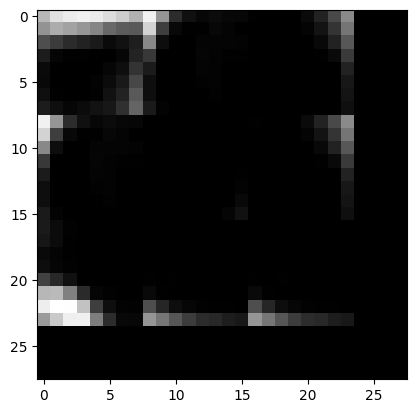

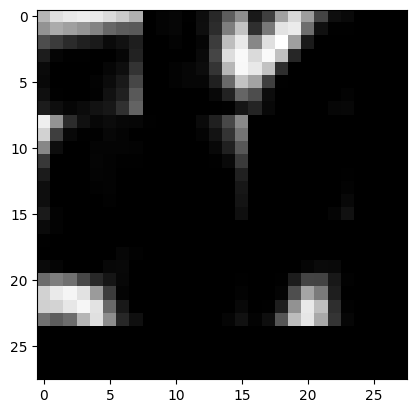

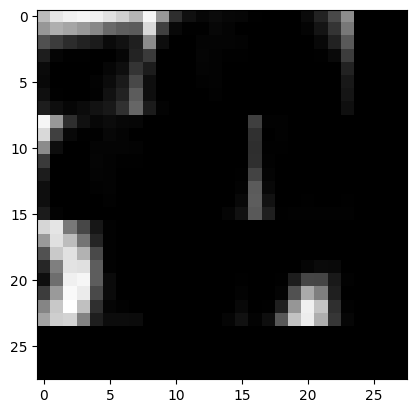

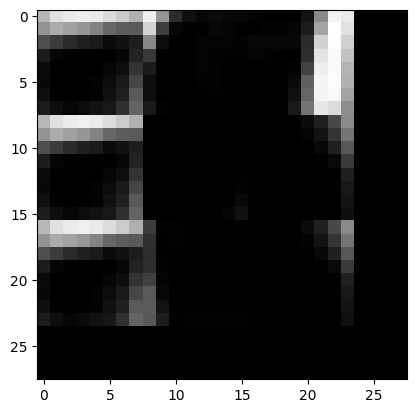

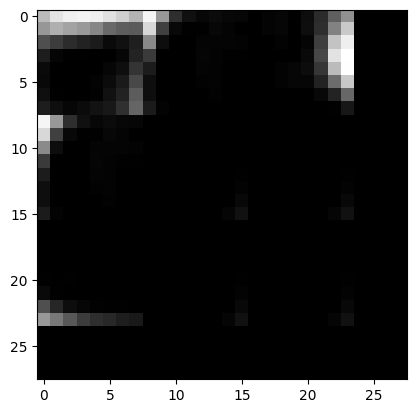

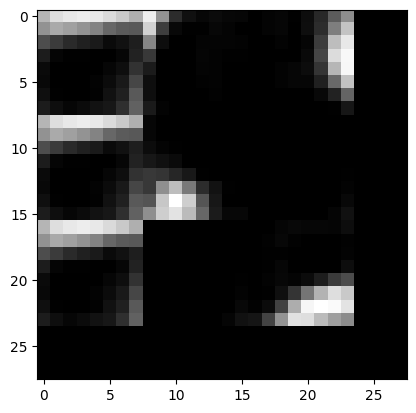

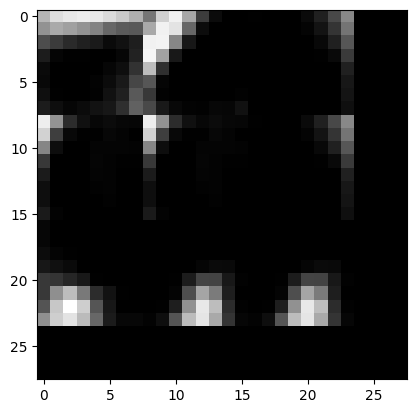

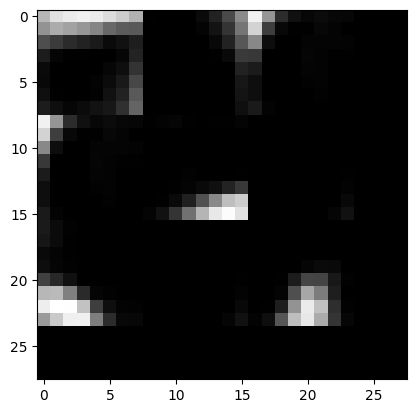

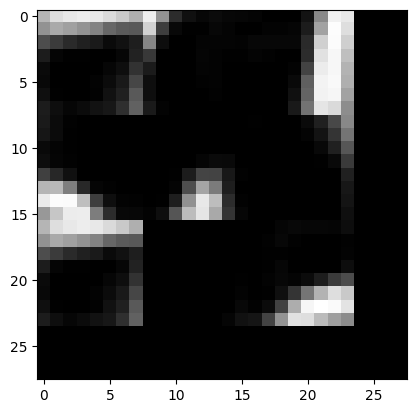

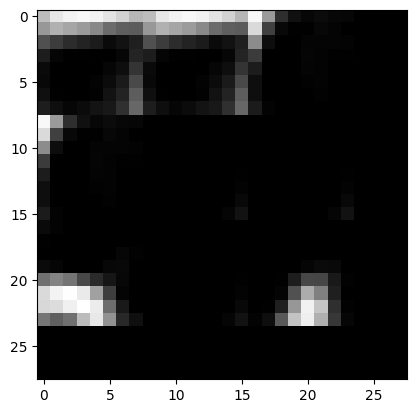

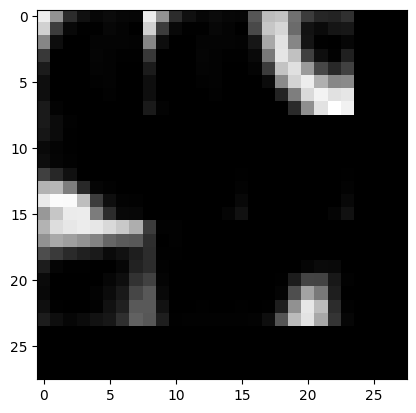

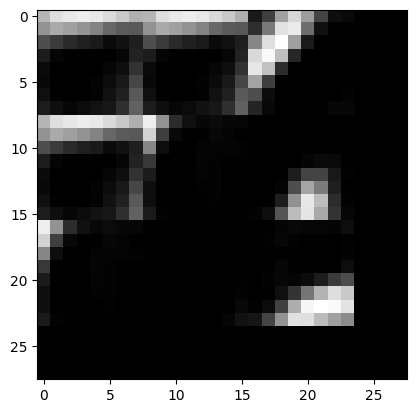

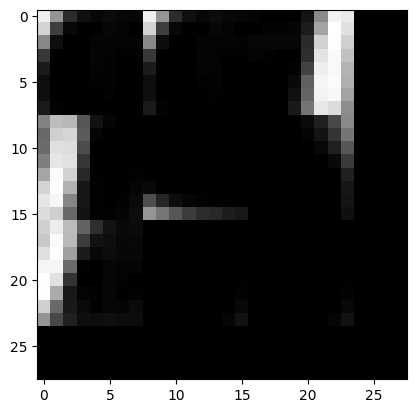

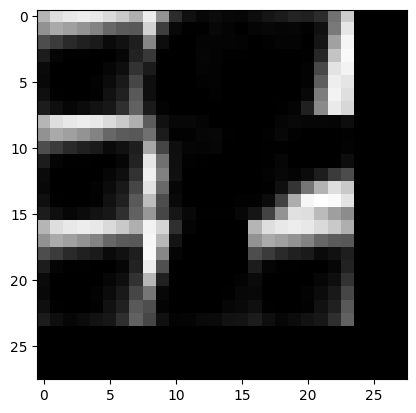

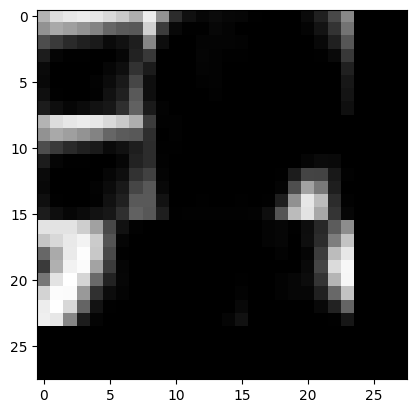

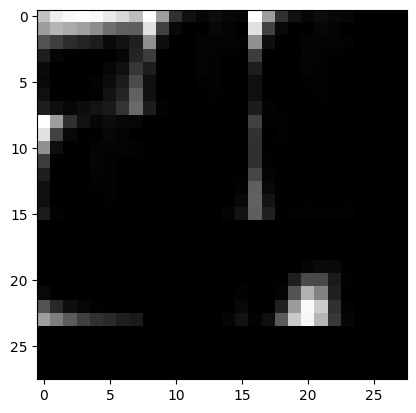

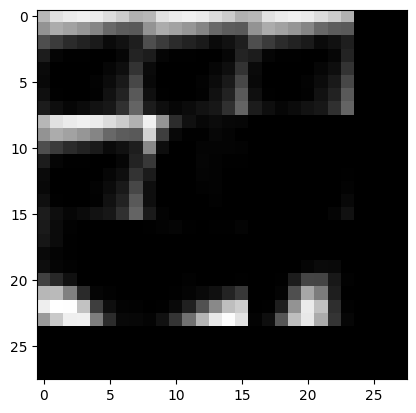

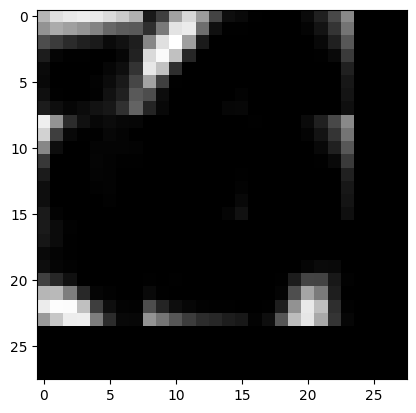

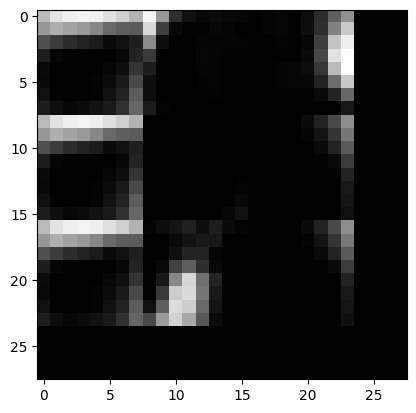

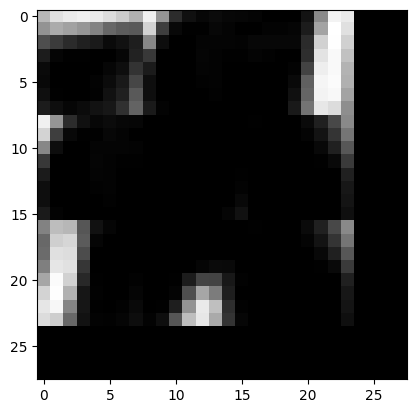

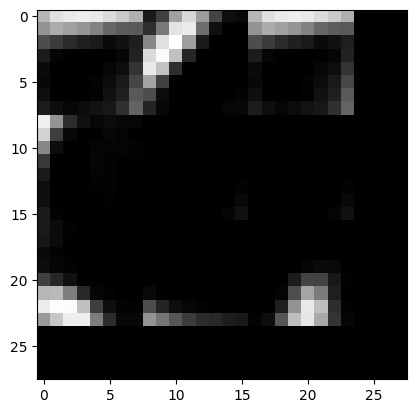

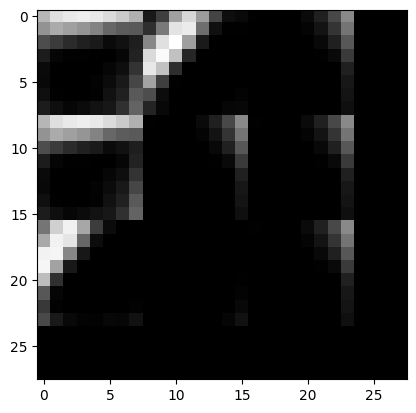

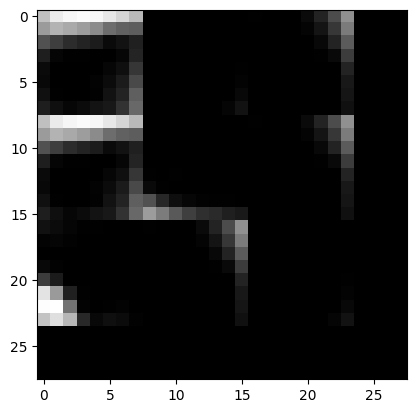

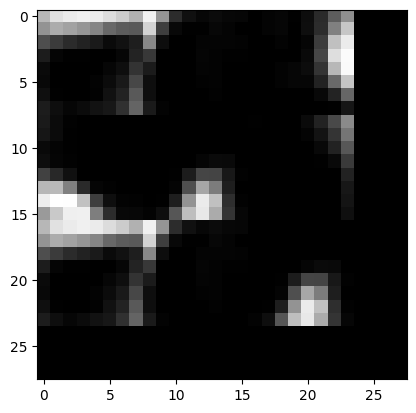

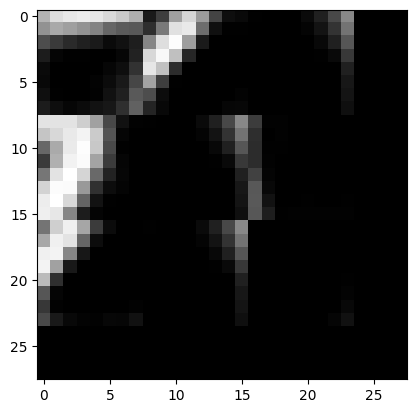

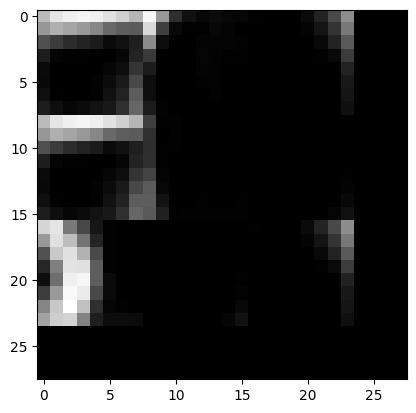

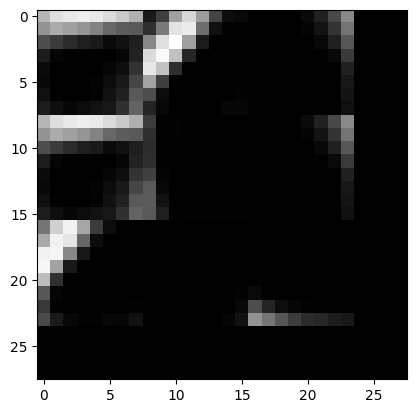

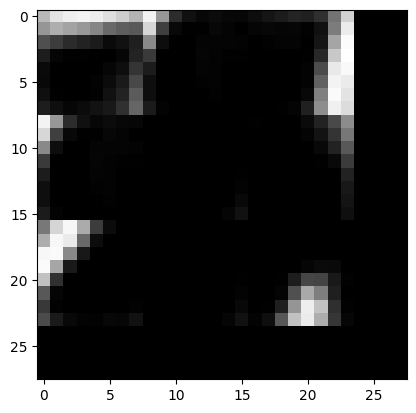

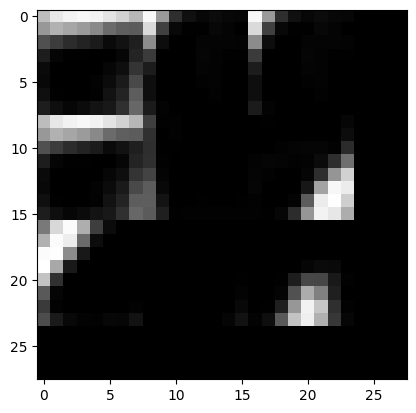

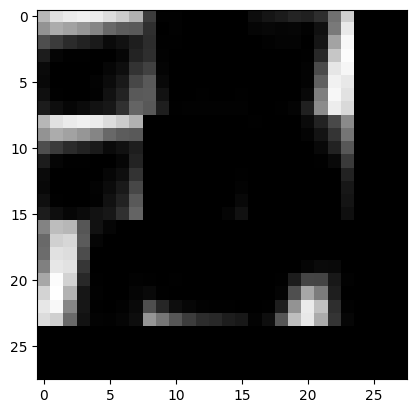

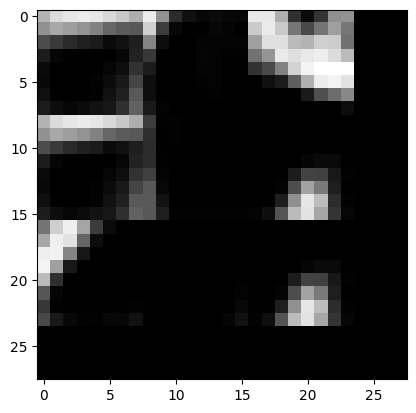

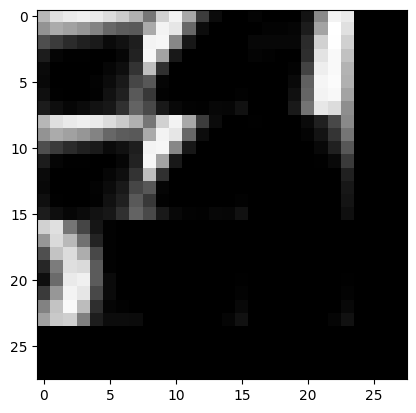

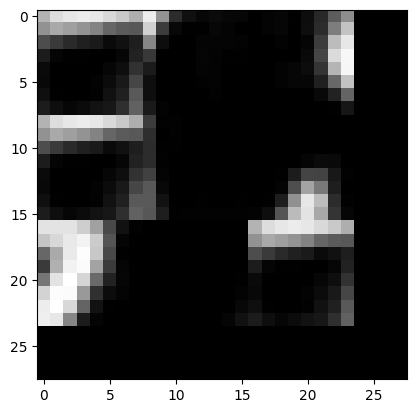

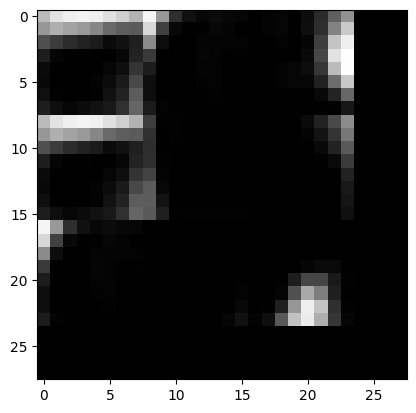

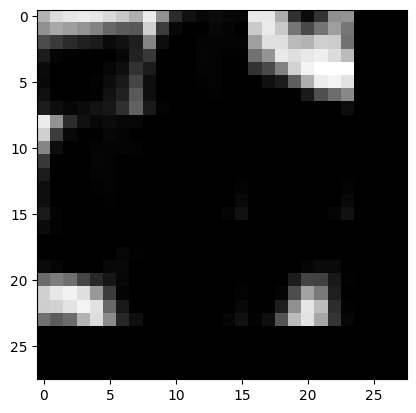

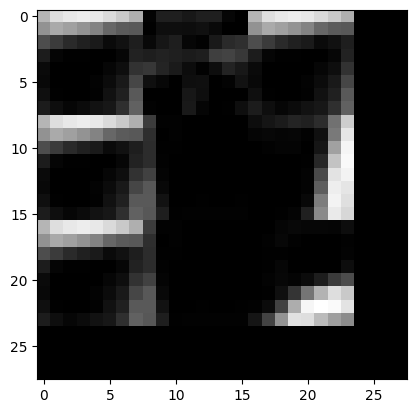

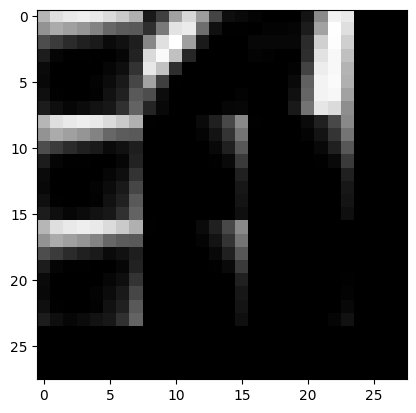

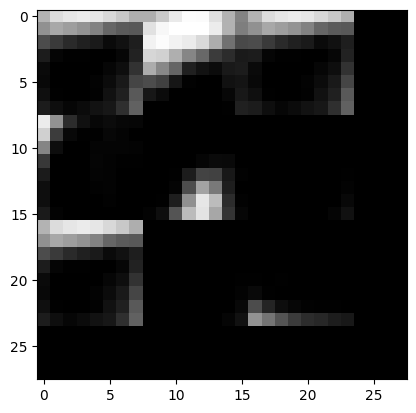

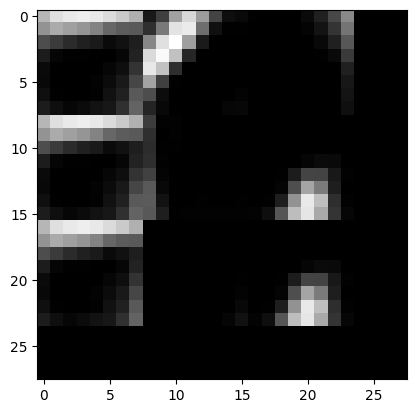

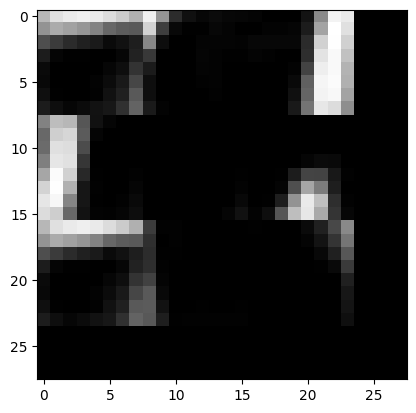

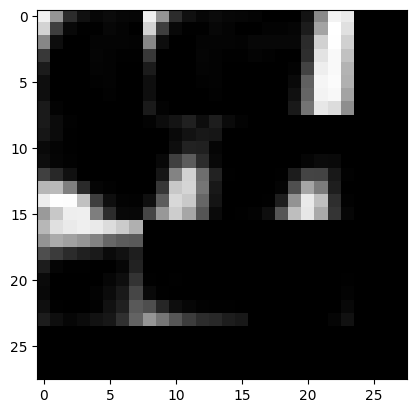

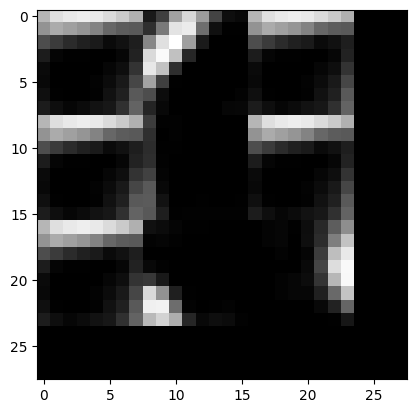

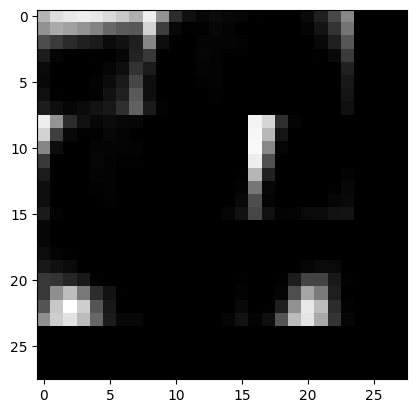

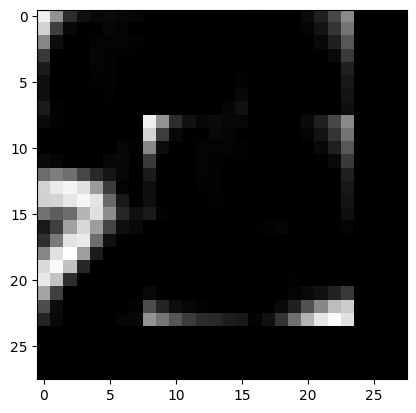

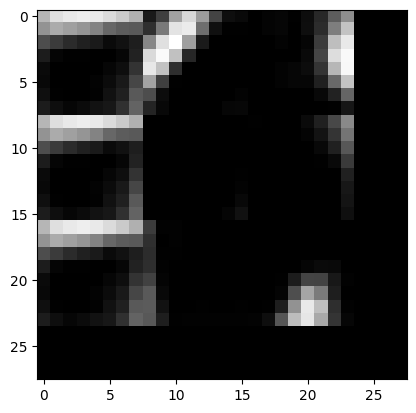

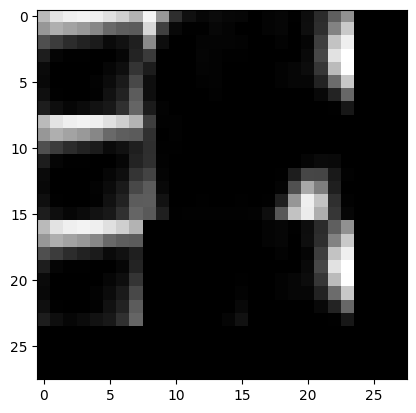

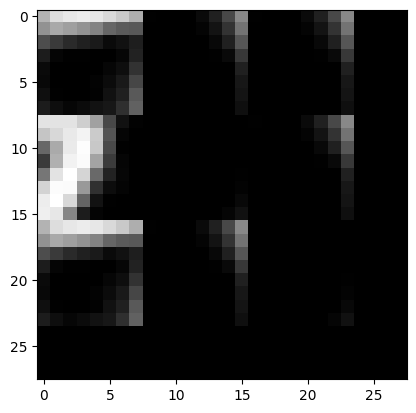

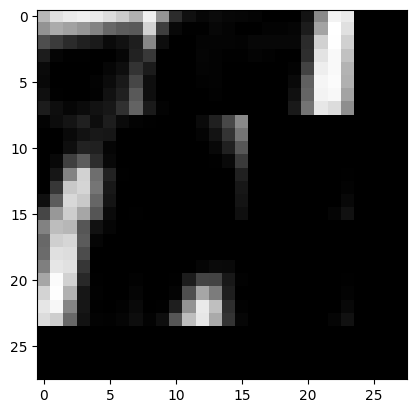

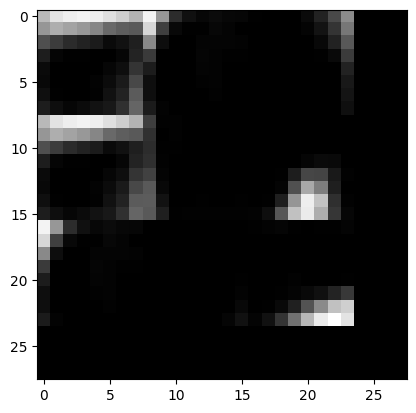

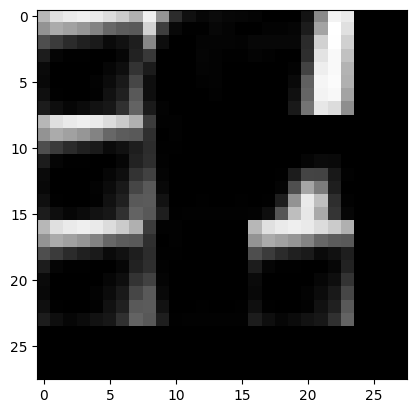

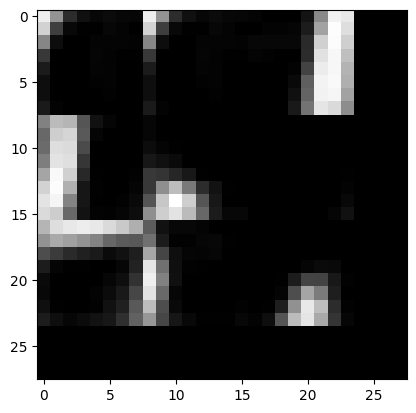

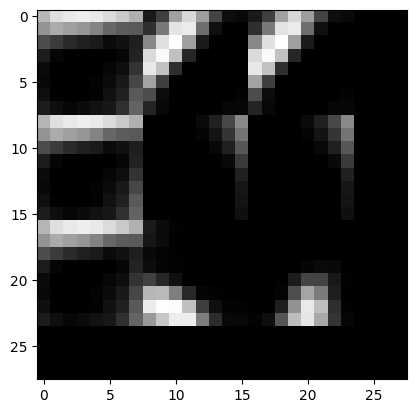

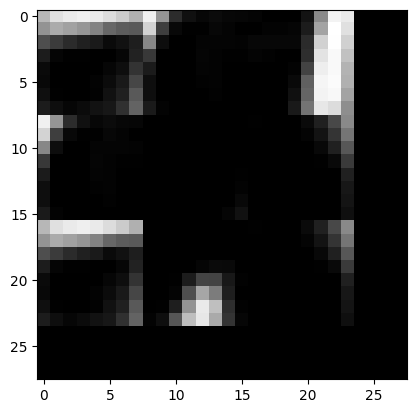

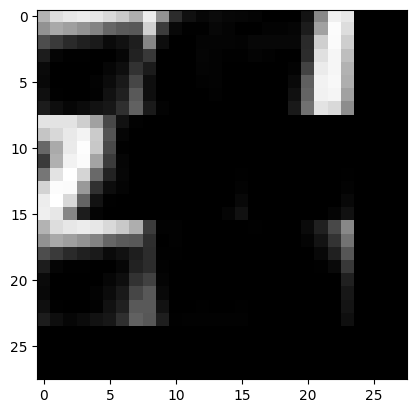

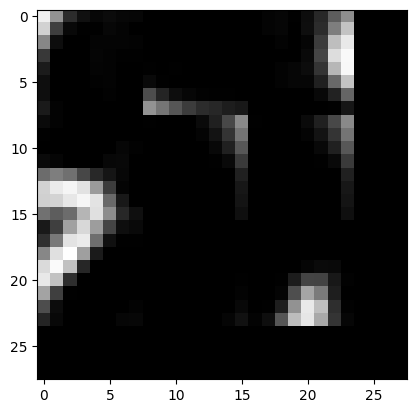

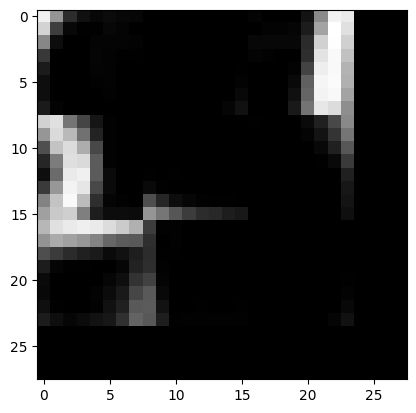

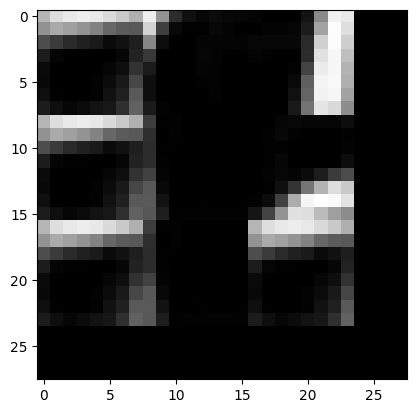

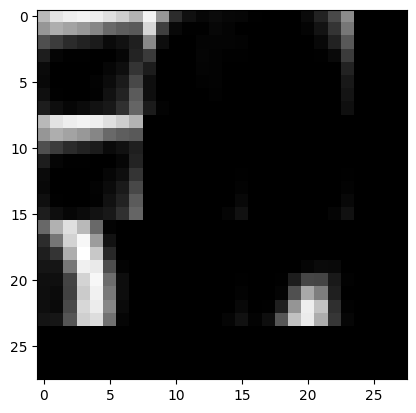

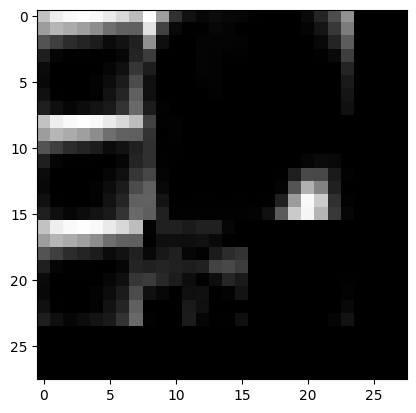

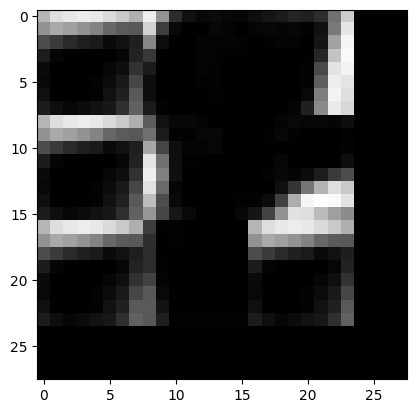

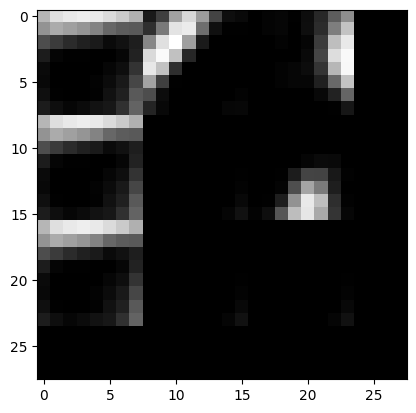

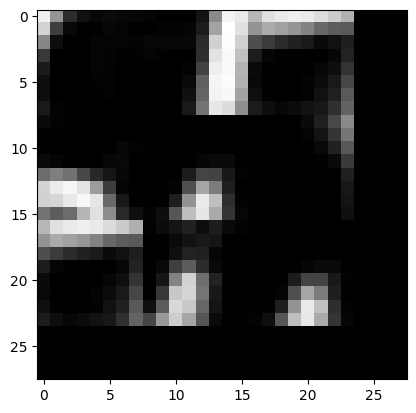

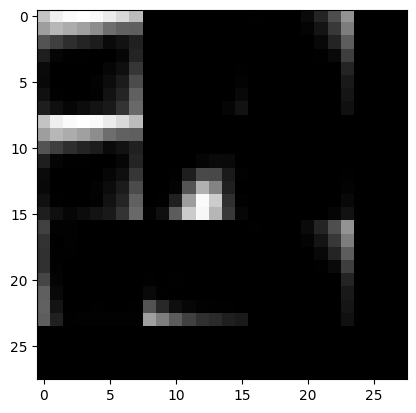

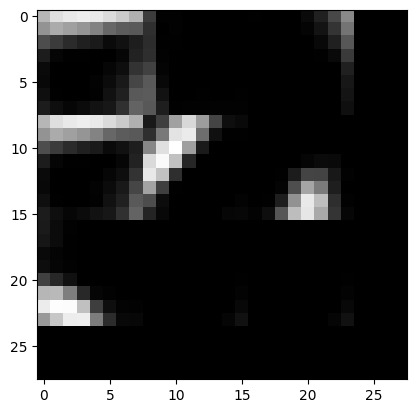

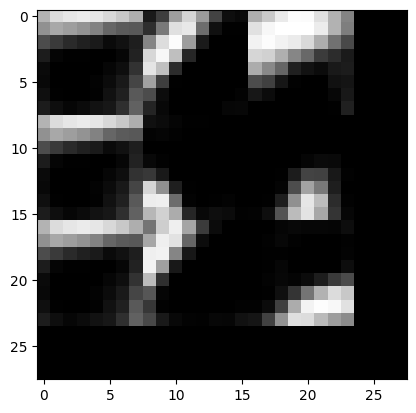

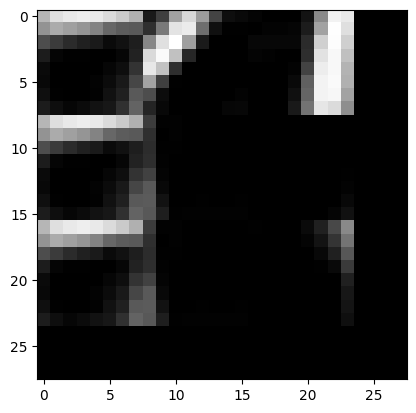

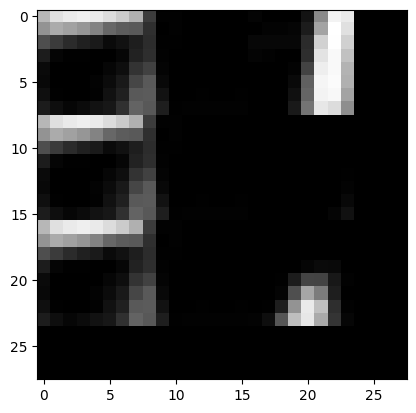

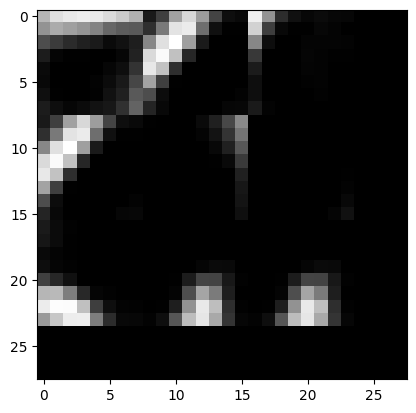

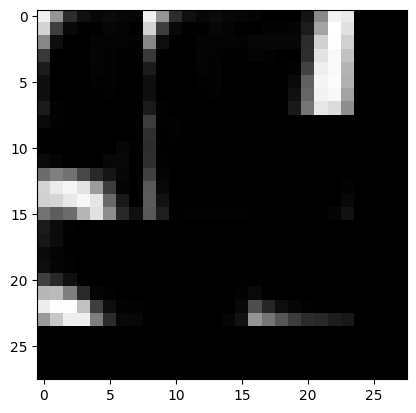

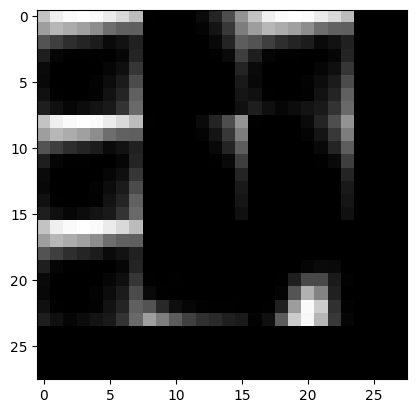

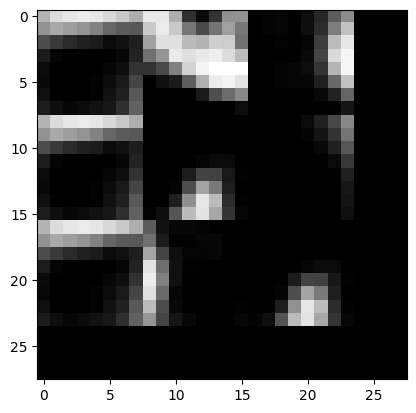

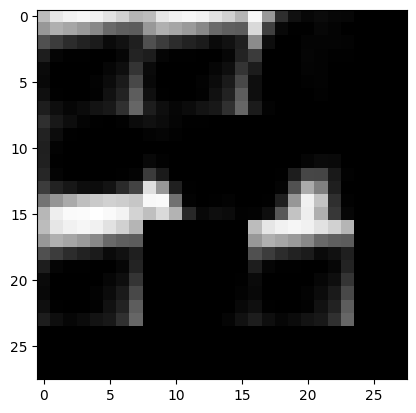

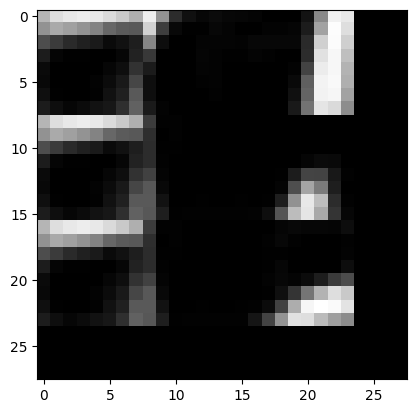

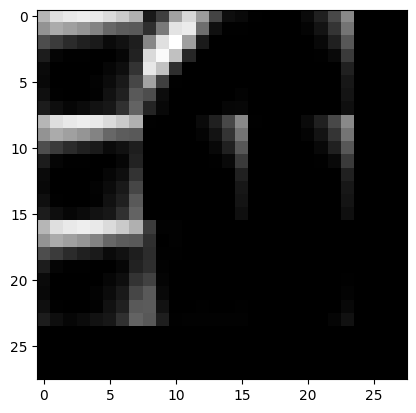

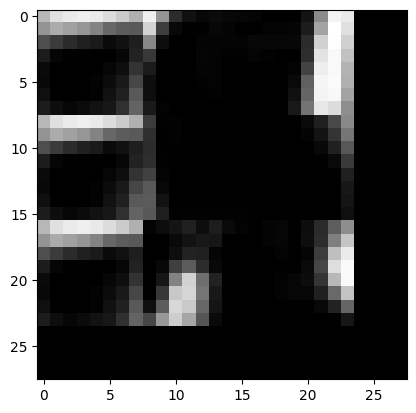

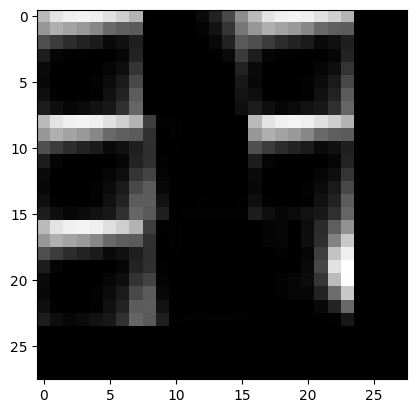

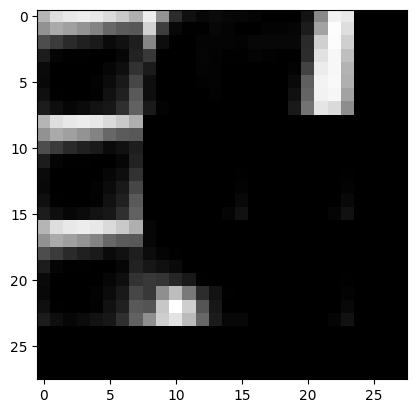

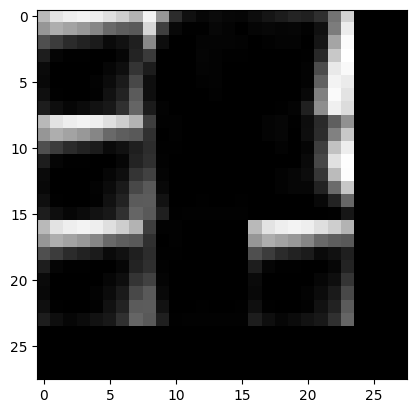

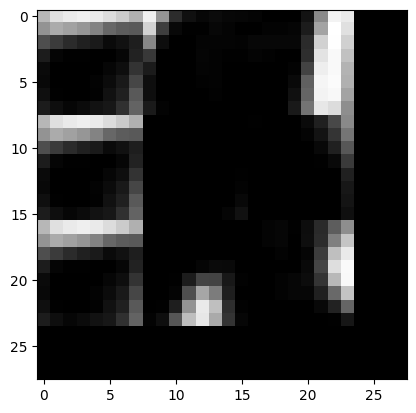

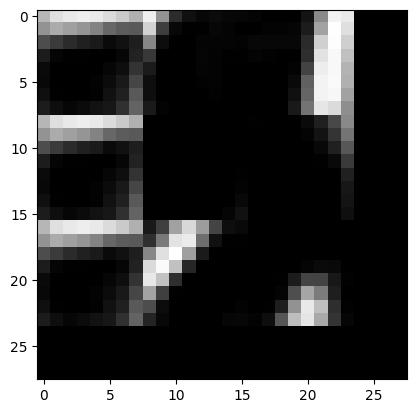

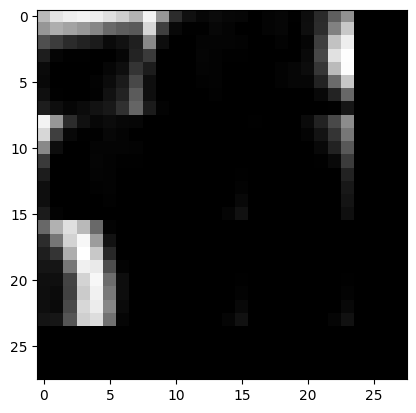

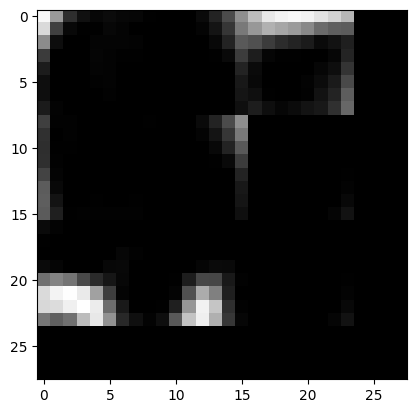

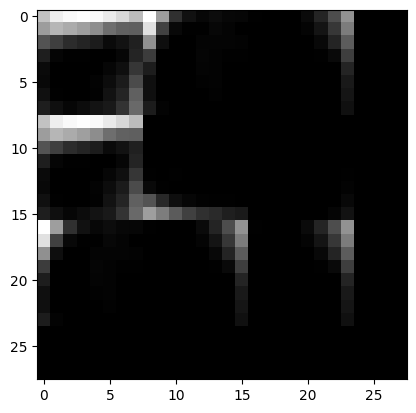

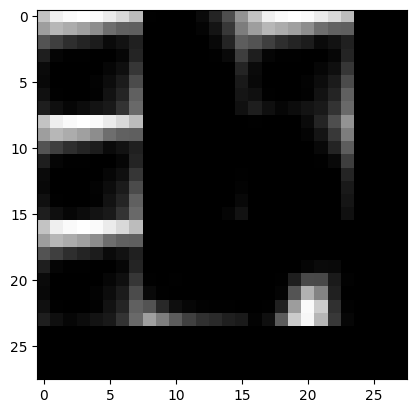

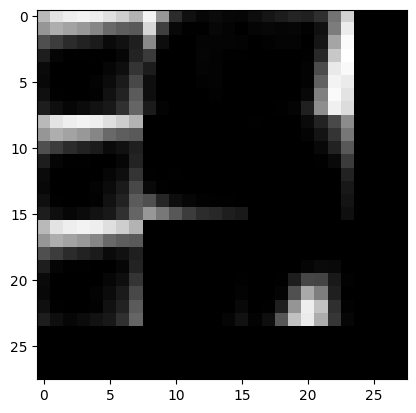

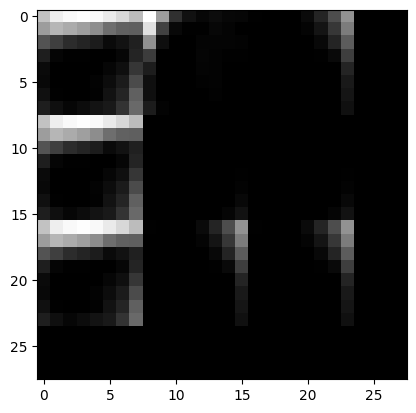

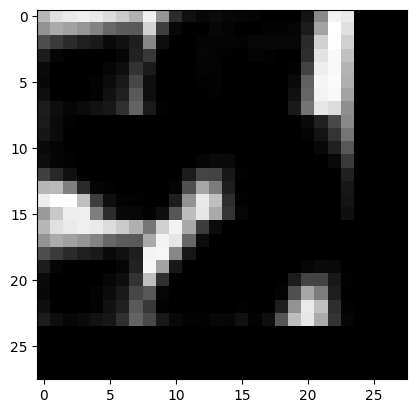

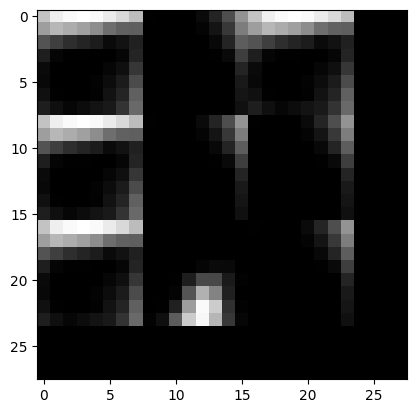

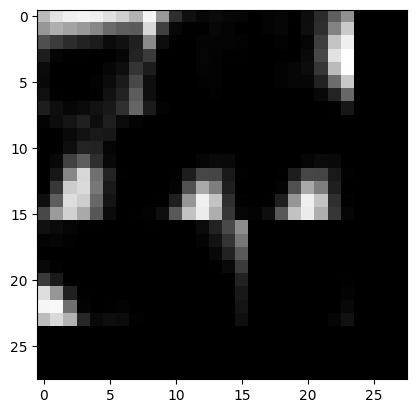

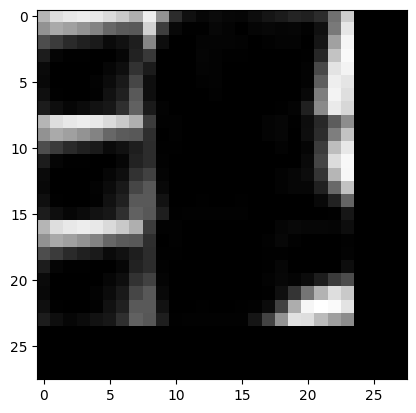

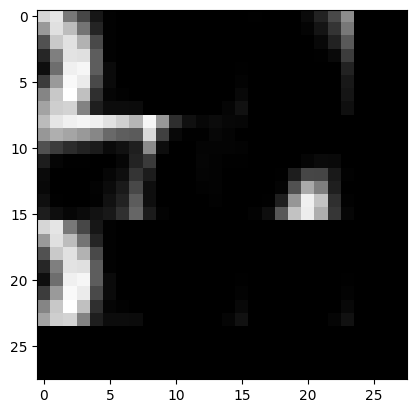

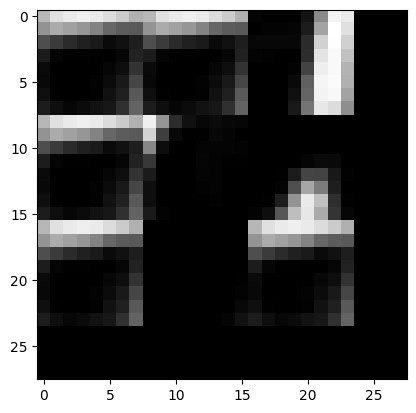

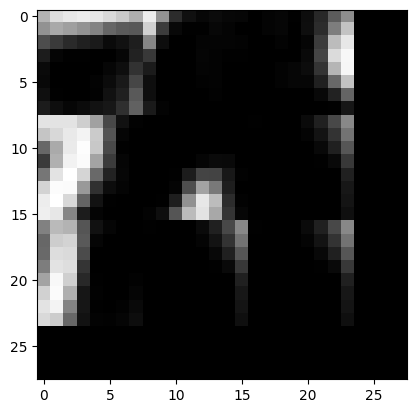

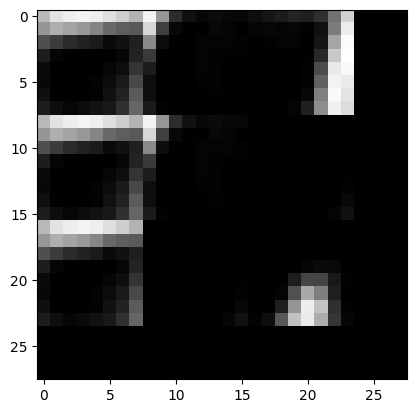

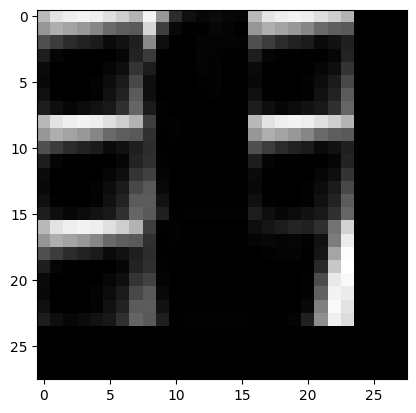

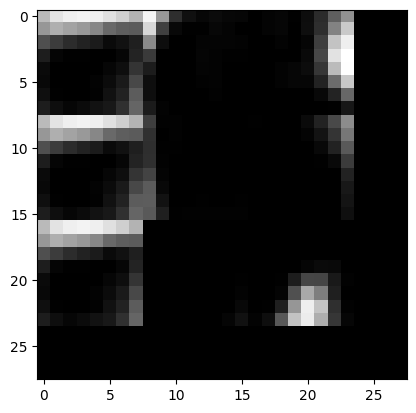

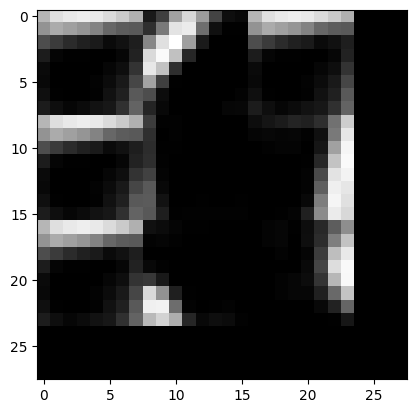

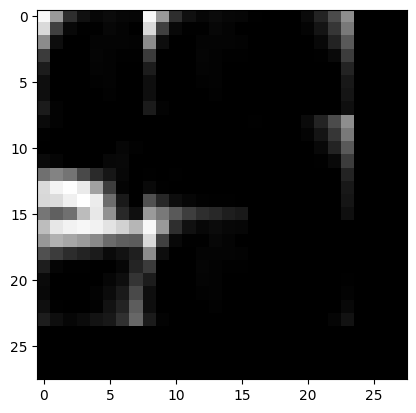

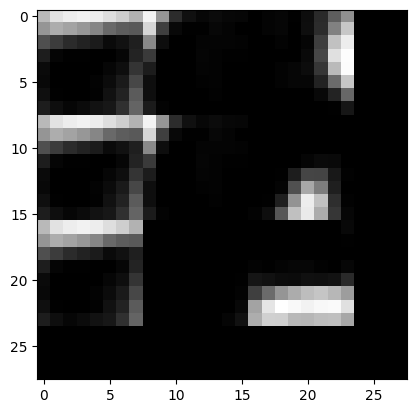

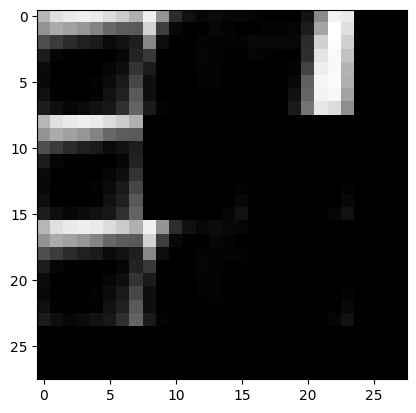

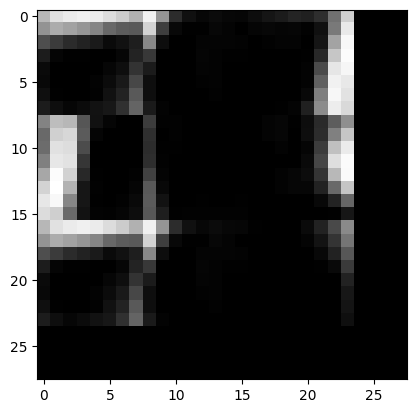

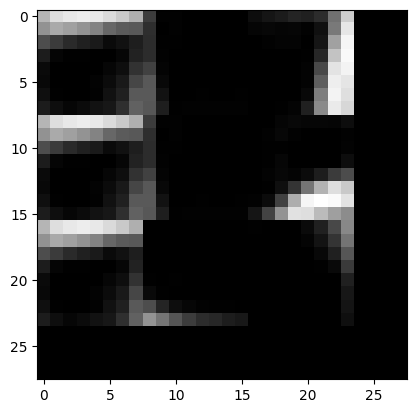

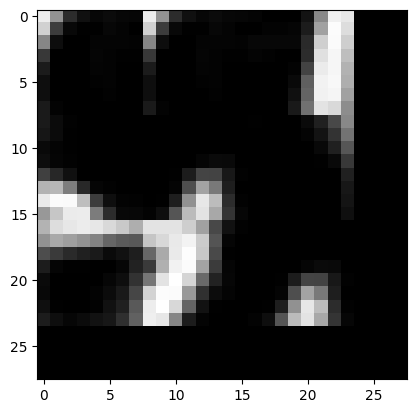

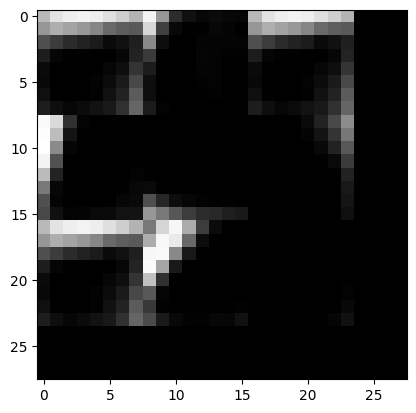

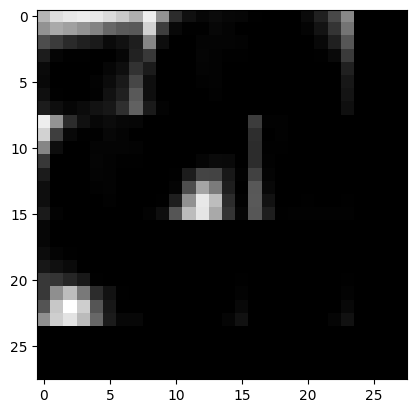

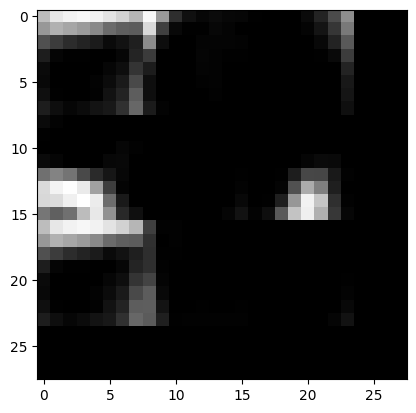

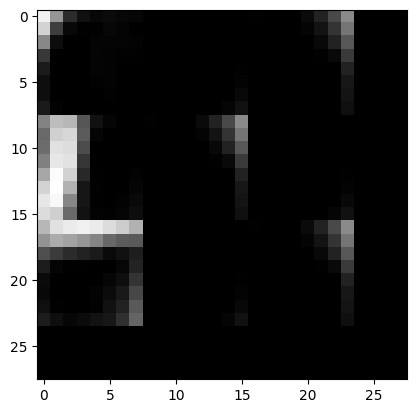

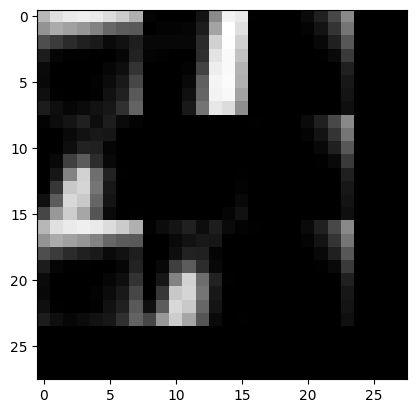

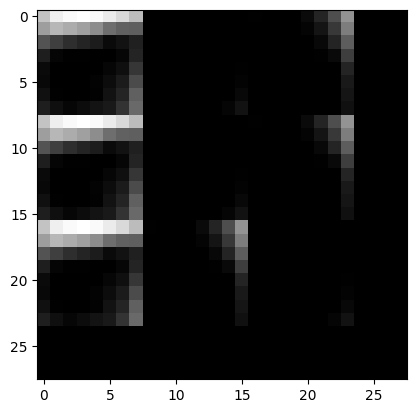

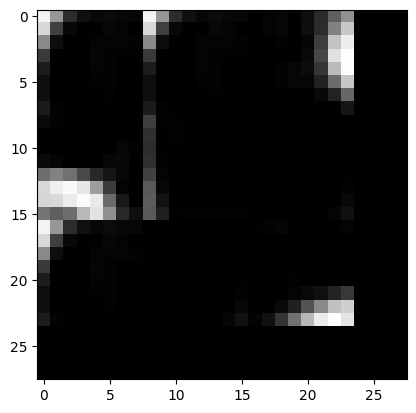

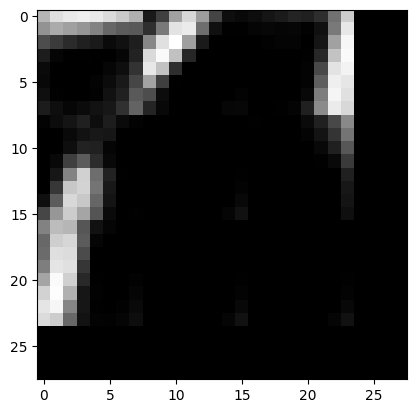

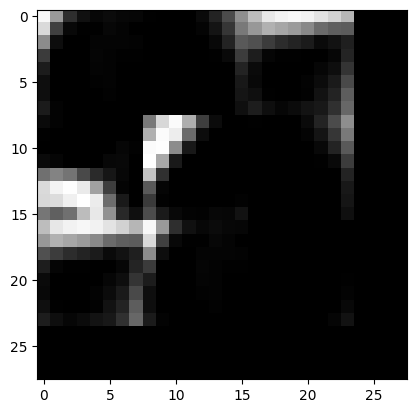

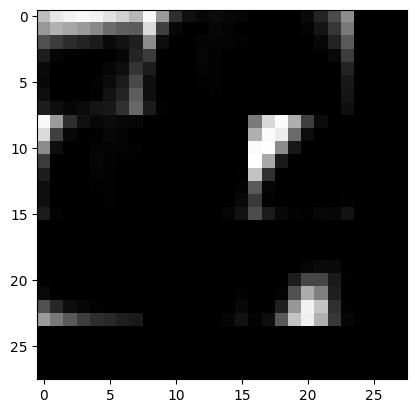

In [135]:
denoised_x_test = denoise_mnist(patches1,gmm,y,8)
denoised_x=np.array(denoised_x_test)
for i in range(denoised_x.shape[0]):
  plt.imshow(denoised_x[i,:,:],cmap=plt.get_cmap('gray'))
  plt.show()


